Day4　ver1.0

・自己回帰モデルにおいてコレログラムを描画しLagについて検討  
・線形回帰モデル、RANSAC、SVRを適用するにあたって、搬送者数を出力として用いる  
・疎構造モデルを試してみる

ver1.1

(1)AR　　  
・trend,seasonaligy,residualに分解  
・先にコレログラムを描いて次数に当たりをつけARモデルを構築  
・lag=1~24までのモデルを総当たりで計算  
・AIC、BIC指標  

(2)SVR   
・搬送者数のばらつきの検証  

ver1.2

(3)GraphicalLasso  
・異常検知の結果を考察　　　　

(4)Gaussian Process追加　　　

In [22]:
import numpy as np
import math
import random
import pandas_profiling as pdp

import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
from pandas.plotting import scatter_matrix


import statsmodels.api as sm  #ARMAで予測する際に用いるライブラリ
from scipy.ndimage.interpolation import shift  #numpyの配列をshiftするための関数
import scipy

from sklearn.linear_model import LinearRegression
from sklearn import cluster, covariance, manifold

import warnings

%matplotlib inline

warnings.filterwarnings('ignore')

# data

In [2]:
# all pref 2016
df2016 = pd.read_excel(
    'data/hot/zenkoku2016.xlsx',
    sheet_name='Sheet1',
    index_col='time',
    parse_dates=['time'])

ta = df2016["temp"]
ws = df2016["wind_speed"]
sr = df2016["solar_radiation"]
rh = df2016["relative_humidity"]

wbgt = []
wbgt = 0.735 * ta + 0.0374 * rh + 0.00292 * ta * rh + 7.619 * sr - 4.557 * sr**2 - 0.0572 * ws - 4.064
wbgt = pd.DataFrame(wbgt, columns=["wbgt"])
df6w = pd.concat([df2016, wbgt], axis=1)  # 4data + wbgt

# lack of data
# display(df6w.isnull().sum())

# drop
df6w.dropna(inplace=True)

wbgt6 = df6w["wbgt"].values  # wbgt value
df6wt = df6w[df6w['place'] == 'tokyo']  # tokyo
df6wn = df6w[df6w['place'] == 'nagoya']  # nagoya
df6wo = df6w[df6w['place'] == 'osaka']  # osaka

# New Data
#  to hospital at tokyo,nagoya,osaka 2016
h2016 = pd.read_excel('data/hot/hansou_2016_tno.xlsx', sheet_name='2016')

h2016t = h2016[h2016['place'] == 'tokyo']
h2016o = h2016[h2016['place'] == 'osaka']
h2016n = h2016[h2016['place'] == 'aichi']  # aichi = nagoya

N6t, N6n, N6o = len(df6wt), len(df6wn), len(df6wo)
N6ht, N6hn, N6ho = len(h2016t), len(h2016n), len(h2016o)

# print("2016 climate data number : ",N6t,N6n,N6o)
# print("2016 to hospital data number :",N6ht,N6ha,N6ho)

# print()
# print("all")
# display(df6w.describe())
# print('tokyo')
# display(df6wt.describe())
# display(h2016t.describe())
# print('nagoya')
# display(df6wn.describe())
# display(h2016a.describe())
# print('osaka')
# display(df6wo.describe())
# display(h2016o.describe())

# all pref 2017
df2017 = pd.read_excel(
    'data/hot/zenkoku2017.xlsx',
    sheet_name='Sheet1',
    index_col='time',
    parse_dates=['time'])

ta = df2017["temp"]
ws = df2017["wind_speed"]
sr = df2017["solar_radiation"]
rh = df2017["relative_humidity"]

wbgt = []
wbgt = 0.735 * ta + 0.0374 * rh + 0.00292 * ta * rh + 7.619 * sr - 4.557 * sr**2 - 0.0572 * ws - 4.064
wbgt = pd.DataFrame(wbgt, columns=["wbgt"])

df7w = pd.concat([df2017, wbgt], axis=1)  # 4data + wbgt

#  lack of data
# display(df7w.isnull().sum())

# drop
df7w.dropna(inplace=True)

wbgt7 = df7w["wbgt"].values  # wbgt value
df7wt = df7w[df7w['place'] == 'tokyo']  # tokyo
df7wn = df7w[df7w['place'] == 'nagoya']  # nagoya
df7wo = df7w[df7w['place'] == 'osaka']  # osaka

# New Data
#  to hospital at tokyo,nagoya,osaka
h2017 = pd.read_excel('data/hot/hansou_2017_tno.xlsx', sheet_name='2017')

h2017t = h2017[h2017['place'] == 'tokyo']
h2017o = h2017[h2017['place'] == 'osaka']
h2017n = h2017[h2017['place'] == 'aichi']  # aichi = nagoya

N7t, N7n, N7o = len(df7wt), len(df7wn), len(df7wo)
N7ht, N7hn, N7ho = len(h2017t), len(h2017n), len(h2017o)

# all pref 2018
df2018 = pd.read_excel(
    'data/hot/zenkoku2018.xlsx',
    sheet_name='Sheet1',
    index_col='time',
    parse_dates=['time'])

ta = df2018["temp"]
ws = df2018["wind_speed"]
sr = df2018["solar_radiation"]
rh = df2018["relative_humidity"]

wbgt = []
wbgt = 0.735 * ta + 0.0374 * rh + 0.00292 * ta * rh + 7.619 * sr - 4.557 * sr**2 - 0.0572 * ws - 4.064
wbgt = pd.DataFrame(wbgt, columns=["wbgt"])

df8w = pd.concat([df2018, wbgt], axis=1)  # 4data + wbgt

#  lack of data
# display(df7w.isnull().sum())

# drop
df8w.dropna(inplace=True)

wbgt8 = df8w["wbgt"].values  # wbgt value
df8wt = df8w[df8w['place'] == 'tokyo']  # tokyo
df8wn = df8w[df8w['place'] == 'nagoya']  # nagoya
df8wo = df8w[df8w['place'] == 'osaka']  # osaka

# New Data
#  to hospital at tokyo,nagoya,osaka
h2018 = pd.read_excel('data/hot/hansou_2018_tno.xlsx', sheet_name='2018')

h2018t = h2018[h2018['place'] == 'tokyo']
h2018o = h2018[h2018['place'] == 'osaka']
h2018n = h2018[h2018['place'] == 'aichi']  # aichi = nagoya

N8t, N8n, N8o = len(df8wt), len(df8wn), len(df8wo)
N8ht, N8hn, N8ho = len(h2018t), len(h2018n), len(h2018o)

In [3]:
#pdp.ProfileReport(df8w)

# AR

## plot

In [4]:
temp6n=df6wn.temp
humid6n=df6wn.relative_humidity
temp7n=df7wn.temp
humid7n=df7wn.relative_humidity
temp8n=df8wn.temp
humid8n=df8wn.relative_humidity
x=range(2208)

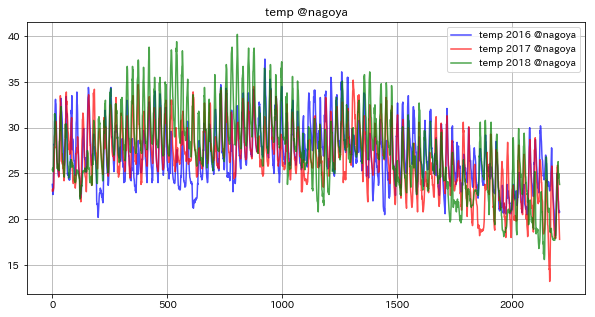

In [5]:
plt.figure(figsize=(10,5))
plt.title('temp @nagoya')
plt.plot(x,temp6n,label='temp 2016 @nagoya',c='b',alpha=0.7)
plt.plot(x,temp7n,label='temp 2017 @nagoya',c='r',alpha=0.7)
plt.plot(x,temp8n,label='temp 2018 @nagoya',c='g',alpha=0.7)
plt.legend(loc='best')
plt.grid()
plt.show()

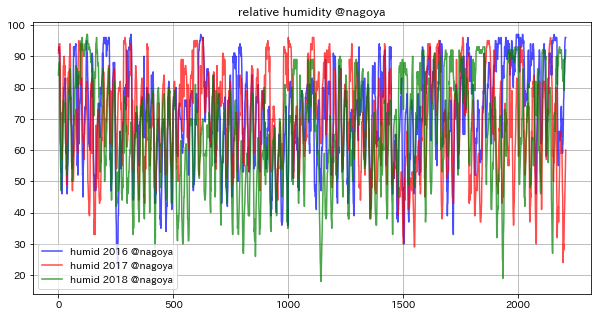

In [6]:
plt.figure(figsize=(10,5))
plt.title('relative humidity @nagoya')
plt.plot(x,humid6n,label='humid 2016 @nagoya',c='b',alpha=0.7)
plt.plot(x,humid7n,label='humid 2017 @nagoya',c='r',alpha=0.7)
plt.plot(x,humid8n,label='humid 2018 @nagoya',c='g',alpha=0.7)
plt.legend(loc='best')
plt.grid()
plt.show()

In [7]:
# temp

df_temp6n=pd.DataFrame(df6wn['temp']) 
df_temp7n=pd.DataFrame(df7wn['temp']) 
df_temp8n=pd.DataFrame(df8wn['temp']) 

## decompose

In [9]:
res6 = sm.tsa.seasonal_decompose(df_temp6n)
res7 = sm.tsa.seasonal_decompose(df_temp7n)
res8 = sm.tsa.seasonal_decompose(df_temp8n)

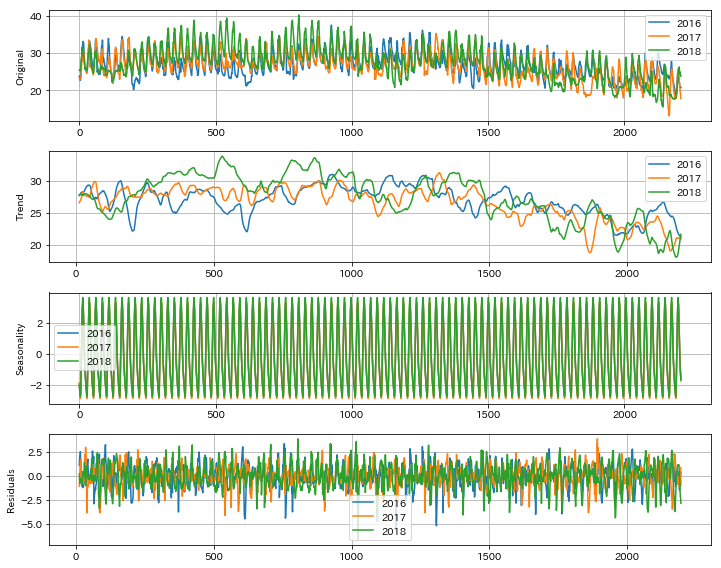

In [10]:
# plot temp about trend,seasonal and residual

plt.figure(figsize=(10, 8)) 

plt.subplot(411) 
plt.plot(x,df_temp6n,label='2016')
plt.plot(x,df_temp7n,label='2017')
plt.plot(x,df_temp8n,label='2018')
plt.grid()
plt.legend()
plt.ylabel('Original')

# trend
plt.subplot(412)
plt.plot(x,res6.trend,label='2016')
plt.plot(x,res7.trend,label='2017')
plt.plot(x,res8.trend,label='2018')
plt.grid()
plt.legend()
plt.ylabel('Trend')

# seasonal
plt.subplot(413)
plt.plot(x,res6.seasonal,label='2016')
plt.plot(x,res7.seasonal,label='2017')
plt.plot(x,res8.seasonal,label='2018')
plt.grid()
plt.legend()
plt.ylabel('Seasonality')

# # residual
plt.subplot(414) 
plt.plot(x,res6.resid,label='2016')
plt.plot(x,res7.resid,label='2017')
plt.plot(x,res8.resid,label='2018')
plt.grid()
plt.legend()
plt.ylabel('Residuals')

plt.tight_layout() 
plt.show()

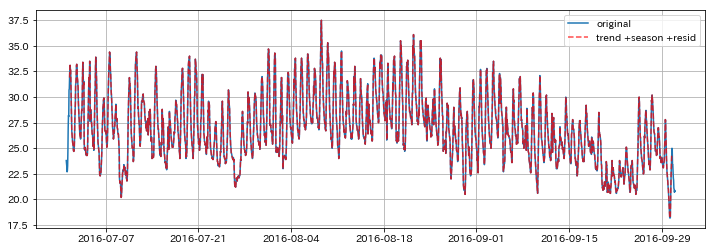

In [11]:
# check
original = df_temp6n
trend = res6.trend
seasonal = res6.seasonal 
residual = res6.resid
sum_three_data = trend + seasonal + residual

plt.figure(figsize=(12, 4))
plt.plot(original, label='original')
plt.grid()
plt.plot(sum_three_data, label='trend +season +resid', linestyle='--',c='r',alpha=0.7)
plt.legend(loc='best') 

## １日平均気温

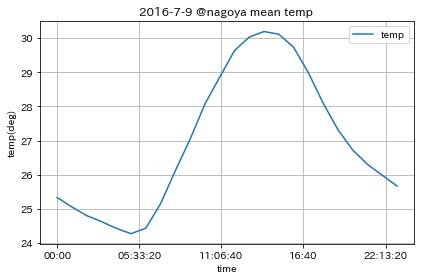

In [13]:
# mean temp

df_temp6n_time_mean = df_temp6n.groupby(df_temp6n.index.time).mean()
df_temp6n_time_mean.plot(kind='line')
plt.title('2016-7-9 @nagoya mean temp ')
plt.grid()
plt.ylabel('temp(deg)')
plt.tight_layout()
plt.show()

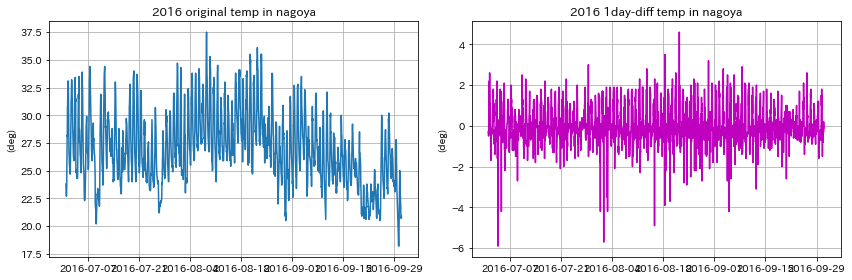

In [14]:
# １Hr差分

fig = plt.figure(figsize=(12, 4))

# original temp
ax1 = fig.add_subplot(121)
plt.plot(df_temp6n)
plt.title('2016 original temp in nagoya')
plt.ylabel('(deg)')
plt.grid()

df_temp6n_diff = df_temp6n - df_temp6n.shift() # 階差系列データ
df_temp6n_diff = df_temp6n_diff.dropna() 

# diff temp
ax2 = fig.add_subplot(122)
plt.plot(df_temp6n_diff,c='m')
plt.title('2016 1day-diff temp in nagoya')
plt.ylabel('(deg)')
plt.grid()

plt.tight_layout() # グラフ間スキマ調整

## 自己相関、偏自己相関

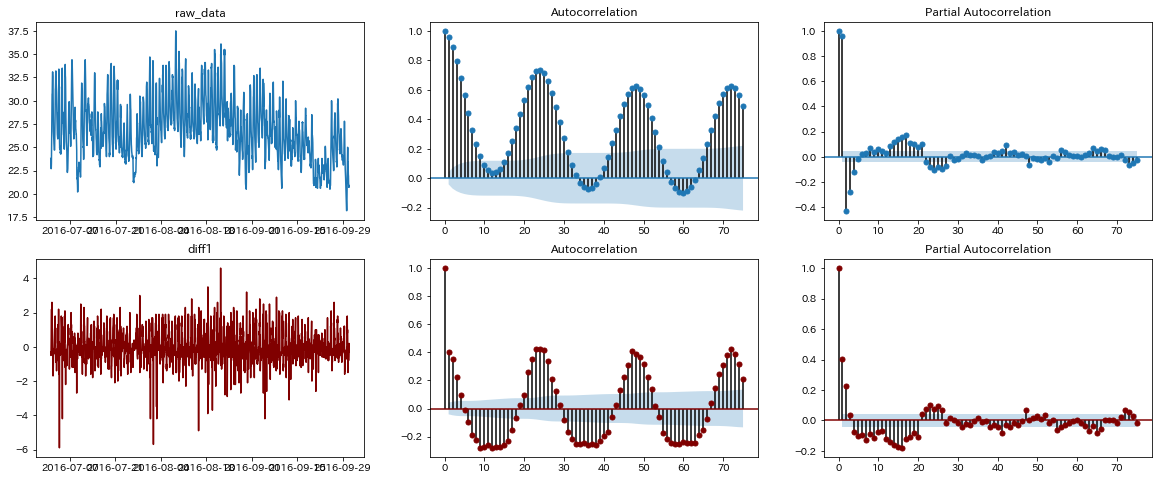

In [15]:
# ACF , PACF 

MAX_LAG = 75 #  >  72 = 24*3

plt.rcParams["font.size"] = 10
fig, ax = plt.subplots(2, 3, figsize=(20, 8))
axes = ax.flatten()
diff_color = "#800000"

axes[0].plot(df_temp6n)
axes[0].set_title("raw_data")
fig = sm.graphics.tsa.plot_acf(df_temp6n, lags=MAX_LAG, ax=axes[1])
fig = sm.graphics.tsa.plot_pacf(df_temp6n, lags=MAX_LAG, ax=axes[2])

axes[3].plot(df_temp6n_diff.dropna(), color=diff_color, alpha=1)
axes[3].set_title("diff1")
fig = sm.graphics.tsa.plot_acf(
    df_temp6n_diff, lags=MAX_LAG, ax=axes[4], color=diff_color)
fig = sm.graphics.tsa.plot_pacf(
    df_temp6n_diff, lags=MAX_LAG, ax=axes[5], color=diff_color)

<font color = 'RED'>偏</font>自己相関係数は、３時間以下、の方が、　２４時間、よりも大きい  
LAG=1,2,3,4,8,10,13-21,23-27,42,48 が有意

## AIC(Akaike's Information Criterion)

In [16]:
# AIC(Akaike's Information Criterion)

import warnings
warnings.filterwarnings('ignore')

# sm.tsa.arma_order_select_ic(y, max_ar=4, max_ma=2, ic='bic', trend='c', model_kw={}, fit_kw={})
# Returns information criteria for many ARMA models

res_selection = sm.tsa.arma_order_select_ic(
    df_temp6n_diff, ic='aic', trend='nc')
res_selection

{'aic':              0            1            2
 0          NaN  5517.080947  5364.670892
 1  5380.392065  5293.908610  5456.707200
 2  5269.630006  5264.584616  4871.697850
 3  5269.158157  5268.843209  4852.731484
 4  5258.936684          NaN  4843.819341, 'aic_min_order': (4, 2)}

$\mathrm {AIC} =-2\ln L+2k$  
$ {\displaystyle L} $:最大尤度、 ${\displaystyle k} $ : パラメータ自由度

## BIC(Bayesian information criterion)

In [17]:
# BIC
res_selection2 = sm.tsa.arma_order_select_ic(
    df_temp6n_diff, ic='bic', trend='c')
res_selection2

{'bic':              0            1            2
 0  5789.233346  5536.175347  5389.465592
 1  5399.487674  5318.704239  5486.298227
 2  5294.425689  5294.179261  4907.872646
 3  5299.653254  5305.037682  4894.610612
 4  5295.131062          NaN  4891.360249, 'bic_min_order': (4, 2)}

$\mathrm {BIC}=-2\ln L+k\ln n$  

${\displaystyle L} $ : 尤度関数、 ${\displaystyle n} $ : 標本の大きさあるいは観測の数、 ${\displaystyle k}$ : 母数あるいは独立変数の数

pはAR（自己回帰）、qはMA（移動平均）、dが差分の次数　　　

AIC と　BIC とも p,q=4,2 を示した

In [18]:
# AIC

sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(4, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()

In [19]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                               temp   No. Observations:                 2208
Model:             SARIMAX(4, 1, 2)x(1, 1, 1, 12)   Log Likelihood               -2450.795
Date:                            Thu, 14 Feb 2019   AIC                           4919.590
Time:                                    23:02:09   BIC                           4970.770
Sample:                                07-01-2016   HQIC                          4938.301
                                     - 10-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3545      0.067     20.194      0.000       1.223       1.486
ar.L2         -0.3701      0.090     -4.105      0.000      -0.547      -0.193
ar.L3          0.1485      0.029      5.078      0.000       0.091       0.206
ar.L4         -0.2515      0.022    -11.609      0.000      -0.294      -0.209
ma.L1         -7.7283      3.379     -2.287      0.022     -14.351      -1.106
ma.L2          6.4146      3.232      1.985      0.047       0.080      12.749
ar.S.L12       0.0530      0.028      1.895      0.058      -0.002       0.108
ma.S.L12      -1.0076      0.010   -102.140      0.000      -1.027      -0.988
sigma2         0.0120      0.012      1.010      0.313      -0.011       0.035
===================================================================================
Ljung-Box (Q):                      232.32   Jarque-Bera (JB):              4100.56
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.35
Prob(H) (two-sided):                  0.31   Kurtosis:                         9.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## AR次数を変えた場合

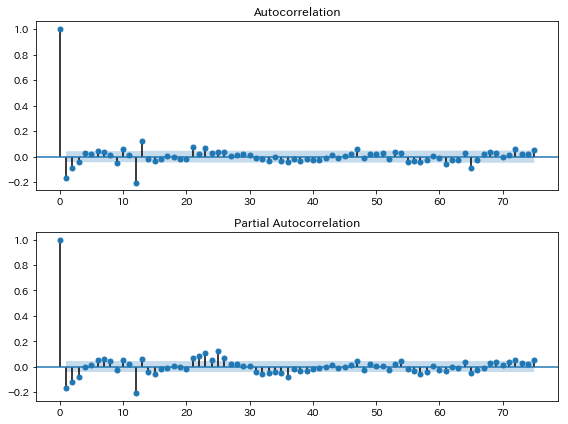

In [22]:
# AIC order=(4, 1, 2)

sarimax_resid = sarimax.resid

fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 

plt.tight_layout()

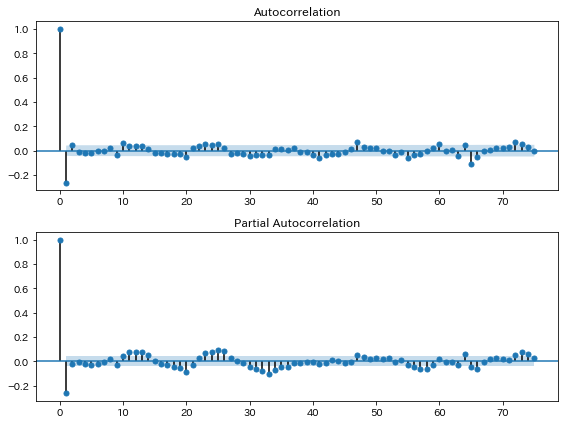

In [24]:
#  no seasonaligy

sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(4, 1, 2),
    seasonal_order=(0,0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

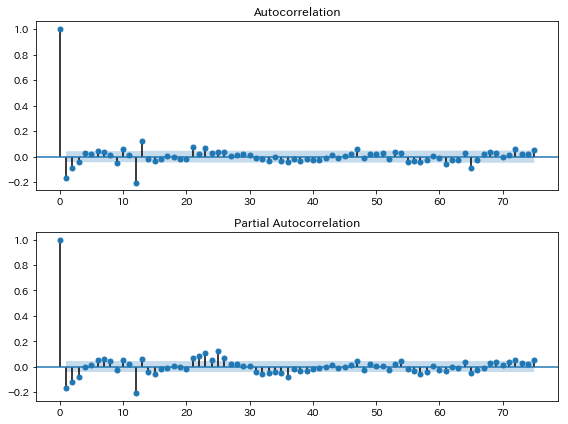

In [19]:
# order=(4, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(4, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

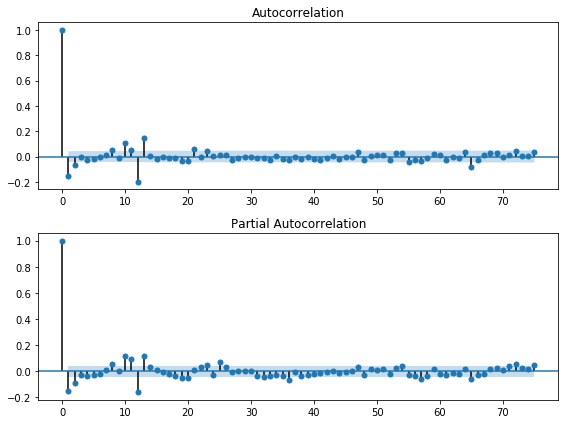

In [22]:
# order=(8, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(8, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

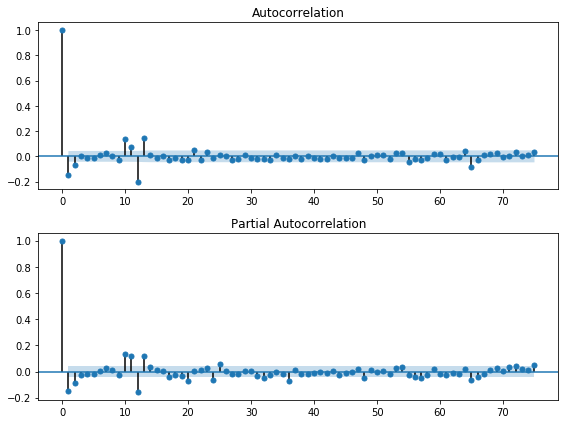

In [23]:
# order=(10, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(10, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

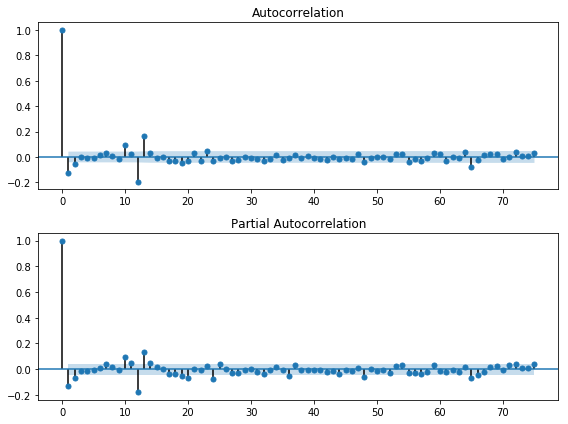

In [35]:
# order=(12, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(12, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

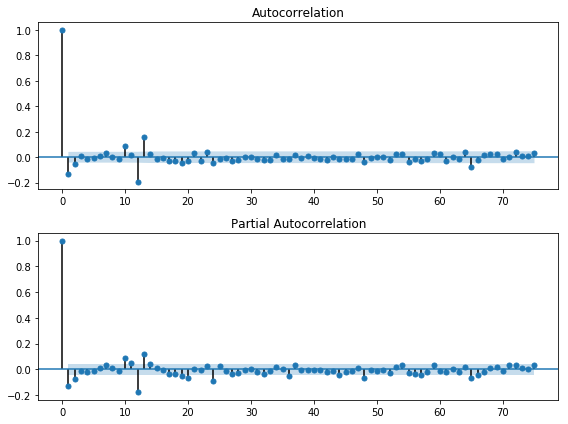

In [24]:
# order=(13, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(13, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

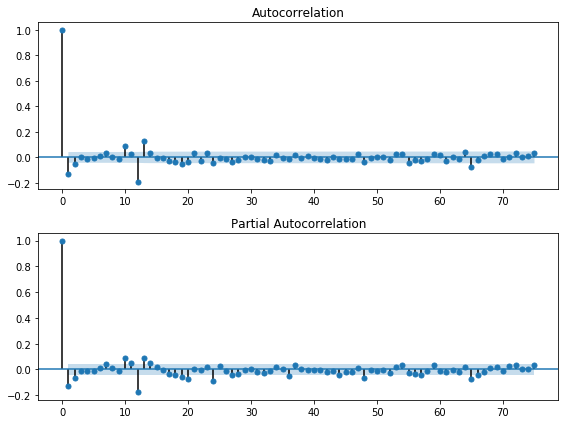

In [25]:
# order=(14, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(14, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

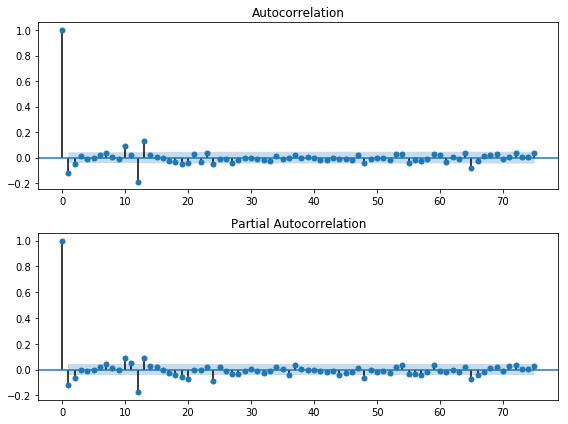

In [26]:
# order=(15, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(15, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

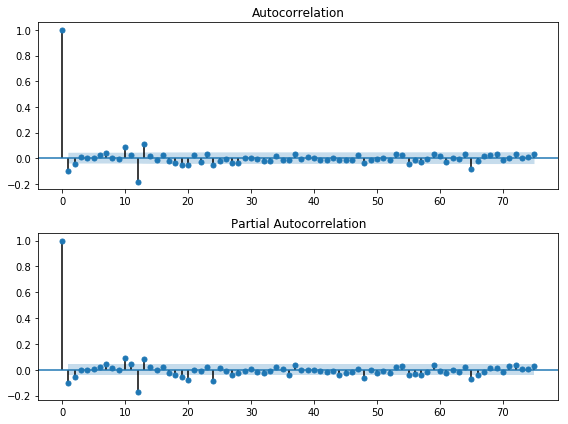

In [27]:
# order=(16, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(16, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

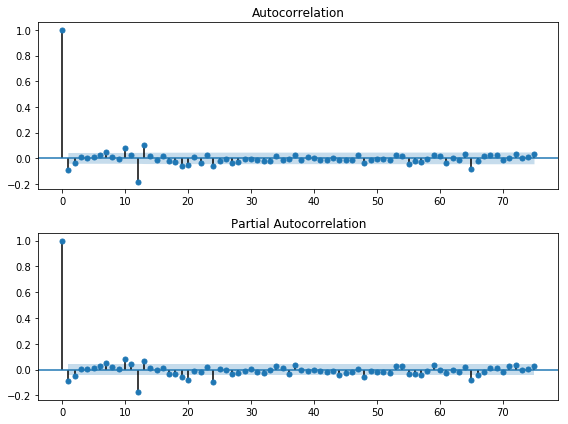

In [29]:
# order=(17, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(17, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

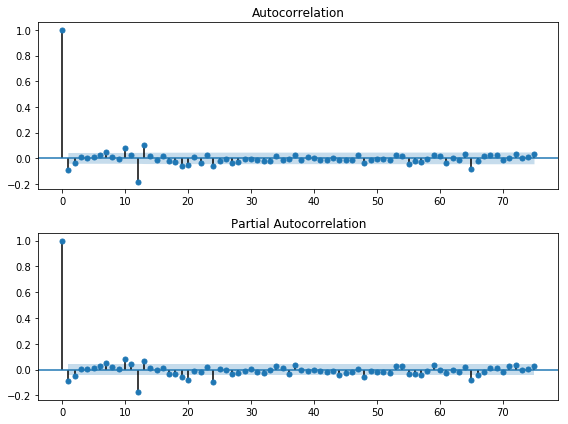

In [30]:
# order=(18, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(18, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

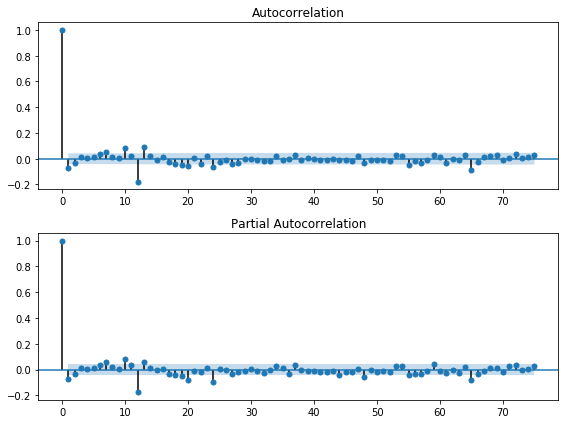

In [32]:
# order=(19, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(19, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

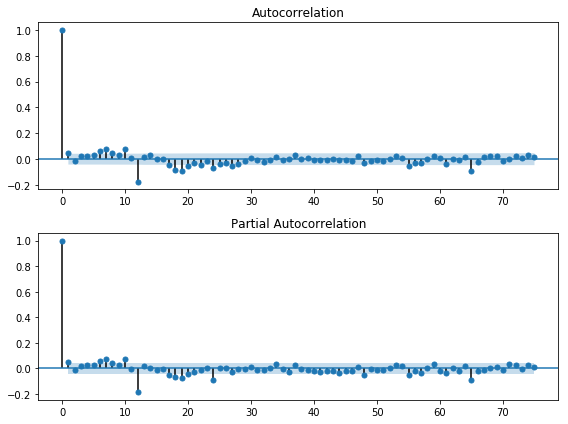

In [33]:
# order=(20, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(20, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

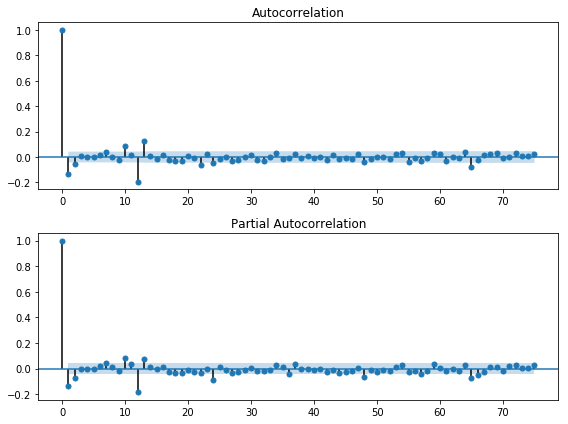

In [34]:
# order=(21, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(21, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

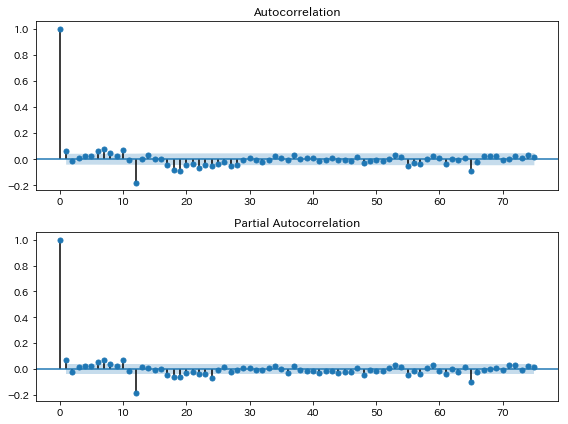

In [25]:
# order=(23, 1, 1)
sarimax = sm.tsa.SARIMAX(
    df_temp6n,
    order=(23, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarimax.summary()
sarimax_resid = sarimax.resid
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sarimax_resid, lags=MAX_LAG, ax=ax1) 
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sarimax_resid, lags=MAX_LAG, ax=ax2) 
plt.tight_layout()

## SARIMAX

自己相関
（ACF: Autocorrelation Function）  
偏自己相関
（PACF:Pertial Autocorrelation Function）  
SARIMA : Seasonal AutoRegressive Integrated Moving Average    
（季節自己回帰和分移動平均）

ARMA(AR+MA) + I =  ARIMA  
ARIMA + S   =  SARIMA   

https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

statsmodels.tsa.statespace.sarimax.SARIMAX(  
    endog,  
    exog=None,  
    order=(1, 0, 0),  
    seasonal_order=(0, 0, 0, 0),  
    trend=None,  
    measurement_error=False,  
    time_varying_regression=False,  
    mle_regression=True,  
    simple_differencing=False,  
    enforce_stationarity=True,  
    enforce_invertibility=True,  
    hamilton_representation=False,  
    concentrate_scale=False,  
    **kwargs)


+ endog (array_like) – The observed time-series process y   
+ exog (array_like, optional) – Array of exogenous regressors, shaped nobs x k.  
+ order (iterable or iterable of iterables, optional) – The (p,d,q) order of the model for the number of AR parameters, differences, and MA   parameters. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. Default is an AR(1) model: (1,0,0).    
+ seasonal_order (iterable, optional) – The (P,D,Q,s) order of the seasonal component of the model for the AR parameters, differences, MA parameters, and periodicity. d must be an integer indicating the integration order of the process, while p and q may either be an integers indicating the AR and MA orders (so that all lags up to those orders are included) or else iterables giving specific AR and / or MA lags to include. s is an integer giving the periodicity (number of periods in season), often it is 4 for quarterly data or 12 for monthly data. Default is no seasonal effect.  
+ trend (str{'n','c','t','ct'} or iterable, optional) – Parameter controlling the deterministic trend polynomial A(t). Can be specified as a string where ‘c’ indicates a constant (i.e. a degree zero component of the trend polynomial), ‘t’ indicates a linear trend with time, and ‘ct’ is both. Can also be specified as an iterable defining the polynomial as in numpy.poly1d, where [1,1,0,1] would denote a+bt+ct3. Default is to not include a trend component.
+ measurement_error (boolean, optional) – Whether or not to assume the endogenous observations endog were measured with error. Default is False.  
+ time_varying_regression (boolean, optional) – Used when an explanatory variables, exog, are provided provided to select whether or not coefficients on the exogenous regressors are allowed to vary over time. Default is False.
+ mle_regression (boolean, optional) – Whether or not to use estimate the regression coefficients for the exogenous variables as part of maximum likelihood estimation or through the Kalman filter (i.e. recursive least squares). If time_varying_regression is True, this must be set to False. Default is True.  
+ simple_differencing (boolean, optional) – Whether or not to use partially conditional maximum likelihood estimation. If True, differencing is performed prior to estimation, which discards the first sD+d initial rows but results in a smaller state-space formulation. If False, the full SARIMAX model is put in state-space form so that all datapoints can be used in estimation. Default is False.  
+ enforce_stationarity (boolean, optional) – Whether or not to transform the AR parameters to enforce stationarity in the autoregressive component of the model. Default is True.  
+ enforce_invertibility (boolean, optional) – Whether or not to transform the MA parameters to enforce invertibility in the moving average component of the model. Default is True.  
+ hamilton_representation (boolean, optional) – Whether or not to use the Hamilton representation of an ARMA process (if True) or the Harvey representation (if False). Default is False.  
+ concentrate_scale (boolean, optional) – Whether or not to concentrate the scale (variance of the error term) out of the likelihood. This reduces the number of parameters estimated by maximum likelihood by one, but standard errors will then not be available for the scale parameter.  
+ **kwargs – Keyword arguments may be used to provide default values for state space matrices or for Kalman filtering options. See Representation, and KalmanFilter for more details.  

## SARIMAパラメータ最適化

モデルパラメータの設定を総当たり実施

In [27]:
# note that need to execute time below code

import warnings
warnings.filterwarnings('ignore')

# order(p, d, q)
min_p = 1
max_p = 3
min_d = 0
max_d = 1
min_q = 0
max_q = 3

# seasonal_order(sp, sd, sq)
min_sp = 0
max_sp = 1
min_sd = 0
max_sd = 1
min_sq = 0
max_sq = 1

test_pattern = (max_p - min_p + 1) * (max_q - min_q + 1) * (
    max_d - min_d + 1) * (max_sp - min_sp + 1) * (max_sq - min_sq + 1) * (
        max_sd - min_sd + 1)
print("pattern:", test_pattern)

sfq = 24
ts = df_temp6n

test_results = pd.DataFrame(
    index=range(test_pattern), columns=["model_parameters", "aic"])
num = 0
for p in range(min_p, max_p + 1):
    for d in range(min_d, max_d + 1):
        for q in range(min_q, max_q + 1):
            for sp in range(min_sp, max_sp + 1):
                for sd in range(min_sd, max_sd + 1):
                    for sq in range(min_sq, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            ts,
                            order=(p, d, q),
                            seasonal_order=(sp, sd, sq, sfq),
                            enforce_stationarity=False,
                            enforce_invertibility=False).fit()
                        test_results.iloc[num][
                            "model_parameters"] = "order=(" + str(
                                p) + "," + str(d) + "," + str(
                                    q) + "), seasonal_order=(" + str(
                                        sp) + "," + str(sd) + "," + str(
                                            sq) + ")"
                        test_results.iloc[num]["aic"] = sarima.aic
                        print(num, '/', test_pattern - 1,
                              test_results.iloc[num]["model_parameters"],
                              test_results.iloc[num]["aic"])
                        num = num + 1

print(test_results[test_results.aic == min(test_results.aic)])

pattern: 192
0 / 191 order=(1,0,0), seasonal_order=(0,0,0) 5777.146091026672
1 / 191 order=(1,0,0), seasonal_order=(0,0,1) 5413.219228481644
2 / 191 order=(1,0,0), seasonal_order=(0,1,0) 5891.067401657127
3 / 191 order=(1,0,0), seasonal_order=(0,1,1) 4571.433409371393
4 / 191 order=(1,0,0), seasonal_order=(1,0,0) 5253.606837165464
5 / 191 order=(1,0,0), seasonal_order=(1,0,1) 4612.375640313025
6 / 191 order=(1,0,0), seasonal_order=(1,1,0) 5323.517851975407
7 / 191 order=(1,0,0), seasonal_order=(1,1,1) 4576.896879528388
8 / 191 order=(1,0,1), seasonal_order=(0,0,0) 5516.526649701564
9 / 191 order=(1,0,1), seasonal_order=(0,0,1) 5297.257013135227
10 / 191 order=(1,0,1), seasonal_order=(0,1,0) 5891.08375198077
11 / 191 order=(1,0,1), seasonal_order=(0,1,1) 4567.928565397337
12 / 191 order=(1,0,1), seasonal_order=(1,0,0) 5211.46899868714
13 / 191 order=(1,0,1), seasonal_order=(1,0,1) 4609.046203848231
14 / 191 order=(1,0,1), seasonal_order=(1,1,0) 5323.773035350156
15 / 191 order=(1,0,1), 

126 / 191 order=(2,1,3), seasonal_order=(1,1,0) 5320.998965439601
127 / 191 order=(2,1,3), seasonal_order=(1,1,1) 4539.553754339049
128 / 191 order=(3,0,0), seasonal_order=(0,0,0) 5266.124025238278
129 / 191 order=(3,0,0), seasonal_order=(0,0,1) 5153.251639101586
130 / 191 order=(3,0,0), seasonal_order=(0,1,0) 5887.382342422135
131 / 191 order=(3,0,0), seasonal_order=(0,1,1) 4559.6030073831635
132 / 191 order=(3,0,0), seasonal_order=(1,0,0) 5123.599459815915
133 / 191 order=(3,0,0), seasonal_order=(1,0,1) 4597.0963181316465
134 / 191 order=(3,0,0), seasonal_order=(1,1,0) 5312.67110988778
135 / 191 order=(3,0,0), seasonal_order=(1,1,1) 4557.1396090295075
136 / 191 order=(3,0,1), seasonal_order=(0,0,0) 5266.614370673975
137 / 191 order=(3,0,1), seasonal_order=(0,0,1) 5150.384367157441
138 / 191 order=(3,0,1), seasonal_order=(0,1,0) 5867.458103746508
139 / 191 order=(3,0,1), seasonal_order=(0,1,1) 4559.002355280632
140 / 191 order=(3,0,1), seasonal_order=(1,0,0) 5121.478203315507
141 / 19

order=(2,1,2), seasonal_order=(0,1,1)  4598.73

In [20]:
ar = sm.tsa.ARIMA(temp6n,order=(2,1,2))
model_ar = ar.fit()

In [42]:
df_temp6n.describe()

temp       y_pred         error
count  2208.000000  2208.000000  2.208000e+03
mean     26.958877    26.962861  1.058919e+00
std       3.260519     3.319774  1.364317e+01
min      18.200000     0.000000  9.623421e-09
25%      24.700000    24.677925  2.030939e-02
50%      26.700000    26.660271  1.160954e-01
75%      29.000000    29.127851  4.401267e-01
max      37.500000    45.434943  5.664400e+02

In [21]:
# 学習データを予測させる
y_pred = sarimax.predict()
df_temp6n["y_pred"] = y_pred
df_temp6n["error"] = (df_temp6n["temp"] - df_temp6n["y_pred"])**2  #　誤差の2乗

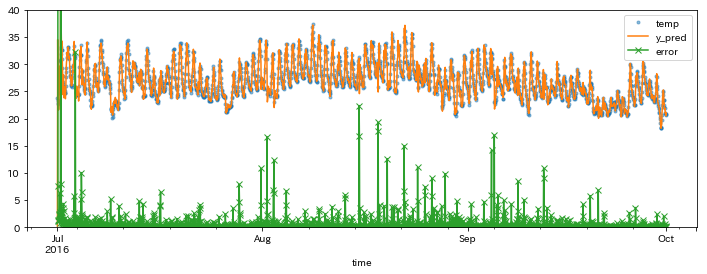

In [22]:
plt.figure(figsize=(12, 4))
df_temp6n["temp"].plot(marker=".", ls="",alpha=0.5)
df_temp6n["y_pred"].plot( ls="-")
df_temp6n["error"].plot(marker="x", ls="-")
plt.ylim([0, 40])
plt.xlabel("time")
plt.legend(["temp", "y_pred", "error"])

誤差大の数値を確認

In [39]:
df_temp6n["error"].sort_values(ascending=False)[:10]

time
2016-07-01 01:00:00    566.440000
2016-07-01 14:00:00    192.212735
2016-07-01 13:00:00    183.194676
2016-07-01 02:00:00    122.011410
2016-07-03 18:00:00     32.247789
2016-08-15 15:00:00     22.417046
2016-08-18 12:00:00     19.315973
2016-08-18 11:00:00     17.810028
2016-09-05 01:00:00     16.988275
2016-08-15 16:00:00     16.757673
Name: error, dtype: float64

In [41]:
df_temp6n[:10]

temp     y_pred       error
time                                            
2016-07-01 01:00:00  23.8   0.000000  566.440000
2016-07-01 02:00:00  23.5  34.545878  122.011410
2016-07-01 03:00:00  23.2  25.944952    7.534764
2016-07-01 04:00:00  22.7  23.824463    1.264417
2016-07-01 05:00:00  22.8  21.595994    1.449630
2016-07-01 06:00:00  23.3  21.804844    2.235493
2016-07-01 07:00:00  24.8  23.219468    2.498080
2016-07-01 08:00:00  27.0  25.924999    1.155627
2016-07-01 09:00:00  28.2  29.053170    0.727899
2016-07-01 10:00:00  28.1  29.657666    2.426325

データの初めに予測値０が入っていること、１時間に１０℃上昇の予測をするなど、実態にそぐわない結果となった（要検討）

# to hospital

## 搬送者数の推移

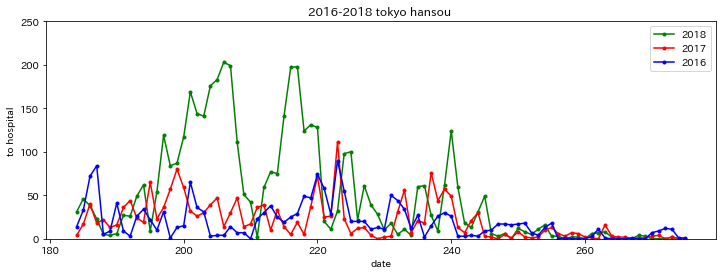

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(h2018t.hansou,marker=".", ls="-",color='g',label='2018')
plt.plot(h2017t.hansou,marker=".", ls="-",color='r',label='2017')
plt.plot(h2016t.hansou,marker=".", ls="-",color='b',label='2016')
plt.ylim([0,250])
plt.legend()
plt.xlabel('date')
plt.ylabel('to hospital')
plt.title('2016-2018 tokyo hansou ')
plt.show()

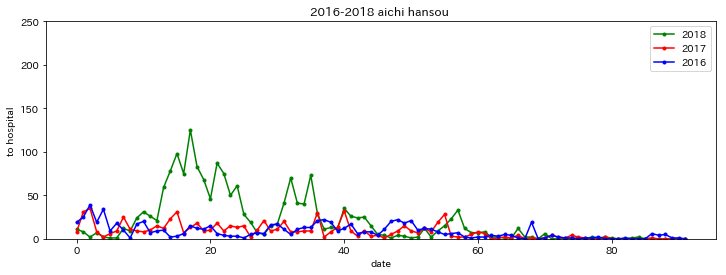

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(h2018n.hansou,marker=".", ls="-",color='g',label='2018')
plt.plot(h2017n.hansou,marker=".", ls="-",color='r',label='2017')
plt.plot(h2016n.hansou,marker=".", ls="-",color='b',label='2016')
plt.ylim([0,250])
plt.legend()
plt.xlabel('date')
plt.ylabel('to hospital')
plt.title('2016-2018 aichi hansou ')
plt.show()

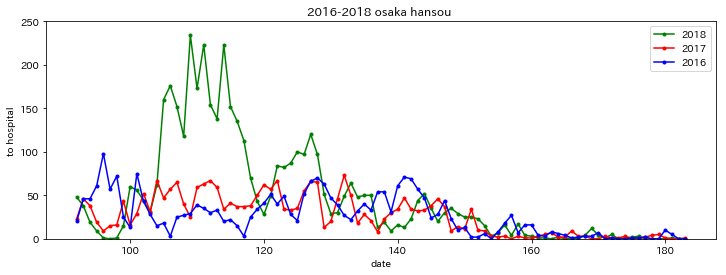

In [27]:
plt.figure(figsize=(12, 4))
plt.plot(h2018o.hansou,marker=".", ls="-",color='g',label='2018')
plt.plot(h2017o.hansou,marker=".", ls="-",color='r',label='2017')
plt.plot(h2016o.hansou,marker=".", ls="-",color='b',label='2016')
plt.ylim([0,250])
plt.legend()
plt.xlabel('date')
plt.ylabel('to hospital')
plt.title('2016-2018 osaka hansou ')
plt.show()

## 搬送者数と計測データとの関係

### 気温VS搬送者

<Figure size 576x360 with 0 Axes>

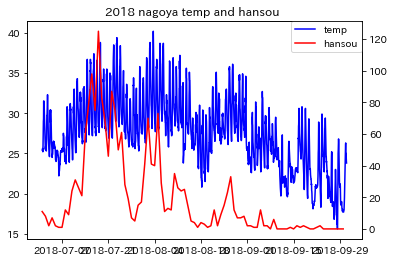

In [28]:
fig = plt.figure(figsize=(8,5))
fig, ax1 = plt.subplots()
 
ax2 = ax1.twinx()
 
ax1.plot(df8wn.index,df8wn.temp,'b-')
ax2.plot(h2018n.date,h2018n.hansou,'r-')

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

plt.title('2018 nagoya temp and hansou ')

ax1.legend(handler1 + handler2, label1 + label2, loc=1, borderaxespad=0.)

### 相対湿度VS搬送者

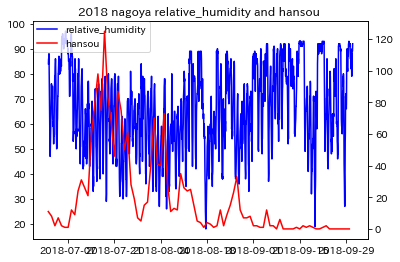

In [29]:
fig, ax1 = plt.subplots()
 
ax2 = ax1.twinx()
 
ax1.plot(df8wn.index,df8wn.relative_humidity,'b-')
ax2.plot(h2018n.date,h2018n.hansou,'r-')
 
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

plt.title('2018 nagoya relative_humidity and hansou ')

ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

### WBGT（湿球黒球温度）VS搬送者

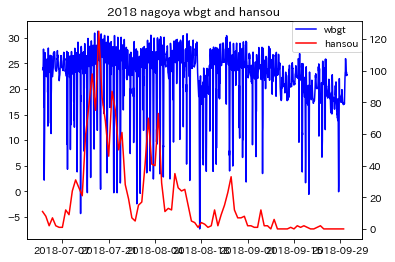

In [30]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(df8wn.index, df8wn.wbgt,'b-')
ax2.plot(h2018n.date, h2018n.hansou, 'r-')

handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()

plt.title('2018 nagoya wbgt and hansou ')

ax1.legend(handler1 + handler2, label1 + label2, loc=1, borderaxespad=0.)

# Linear Regression

In [31]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

In [32]:
df6wn_1=df6wn.groupby(df6wn.index.date).max()
df7wn_1=df7wn.groupby(df7wn.index.date).max()
df8wn_1=df8wn.groupby(df8wn.index.date).max()

## １日最大気温　2016 名古屋

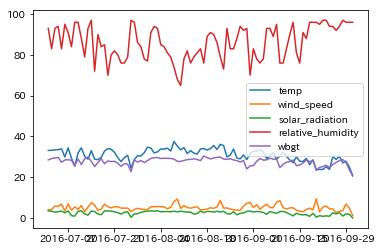

In [33]:
# max values in a day

df6wn_1.plot()

## １日最大気温　2017 名古屋

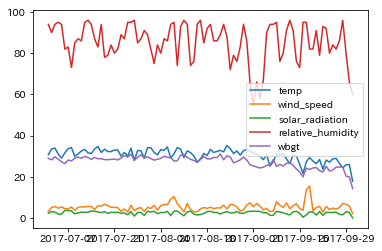

In [34]:
df7wn_1.plot()

## １日最大気温　2018 名古屋

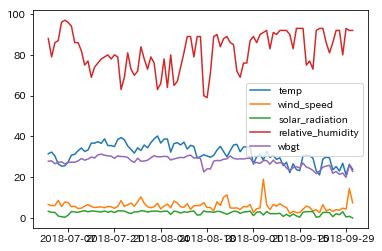

In [35]:
df8wn_1.plot()

## １日平均

In [36]:
df6wn_2=df6wn.groupby(df6wn.index.date).mean()

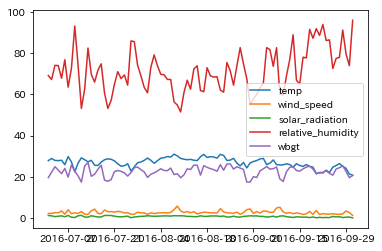

In [37]:
# mean values in a day
df6wn_2.plot()

In [38]:
df6wn_3=df6wn.groupby(df6wn.index.date).min()

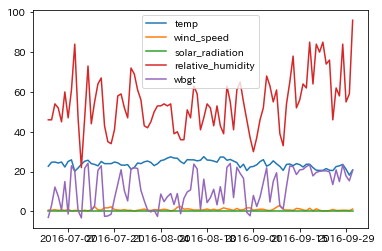

In [39]:
df6wn_3.plot()

## Linear Regression plot

coef :  [1.78393221] intercept :  -46.716


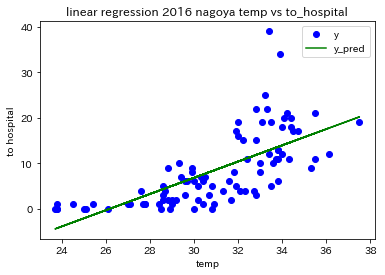

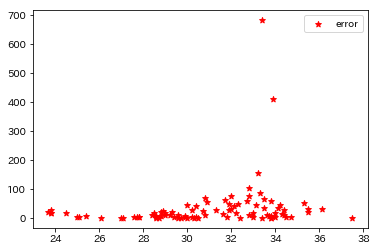

In [40]:
# max temp

x=df6wn_1['temp'][0:92].values
y= h2016n.hansou.values

X = x.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("coef : ", reg.coef_, "intercept : ", reg.intercept_.round(3))

y_pred = reg.predict(X)
error = (y - y_pred)**2

plt.plot(x, y, 'bo')
plt.plot(x, y_pred, marker='', ls="-",c='g')

plt.legend(["y", "y_pred"])
plt.xlabel("temp")
plt.ylabel("to hospital")
plt.title("linear regression 2016 nagoya temp vs to_hospital")

plt.show()

plt.scatter(x, error, marker="*",c="r")

plt.legend(["error"])
plt.show()

In [41]:
error[error.argsort(axis=0)[::-1][:3]]

array([682.89074725, 409.66619318, 155.97424251])

In [42]:
df6wn_1.iloc[error.argsort(axis=0)[::-1][:3]]

place  temp  wind_speed  solar_radiation  relative_humidity  \
2016-07-03  nagoya  33.4         5.8             2.85               93.0   
2016-07-05  nagoya  33.9         6.8             3.37               83.0   
2016-07-02  nagoya  33.2         4.1             3.25               83.0   

                 wbgt  
2016-07-03  29.438349  
2016-07-05  27.303186  
2016-07-02  29.138763

coef :  [-0.17123509] intercept :  23.128


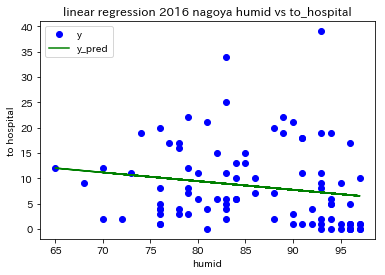

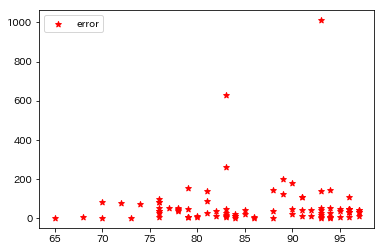

In [43]:
# max humid

x=df6wn_1['relative_humidity'][0:92].values
y= h2016n.hansou.values

X = x.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("coef : ", reg.coef_, "intercept : ", reg.intercept_.round(3))

y_pred = reg.predict(X)
error = (y - y_pred)**2

plt.plot(x, y, 'bo')
plt.plot(x, y_pred, marker='', ls="-",c='g')

plt.legend(["y", "y_pred"])
plt.xlabel("humid")
plt.ylabel("to hospital")
plt.title("linear regression 2016 nagoya humid vs to_hospital")

plt.show()

plt.scatter(x, error, marker="*",c="r")

plt.legend(["error"])
plt.show()

In [44]:
error[error.argsort(axis=0)[::-1][:3]]

array([1011.01561162,  629.21311784,  258.69894289])

coef :  [5.19785964] intercept :  -4.535


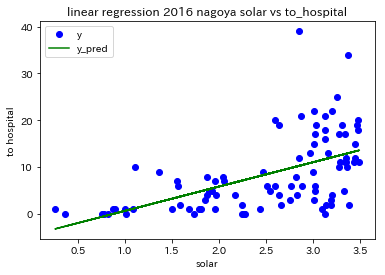

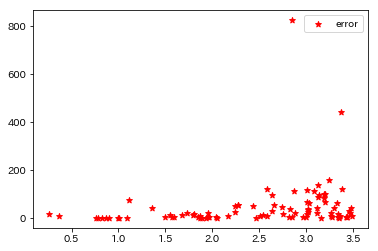

In [45]:
# max solar

x=df6wn_1['solar_radiation'][0:92].values
y= h2016n.hansou.values

X = x.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("coef : ", reg.coef_, "intercept : ", reg.intercept_.round(3))

y_pred = reg.predict(X)
error = (y - y_pred)**2

plt.plot(x, y, 'bo')
plt.plot(x, y_pred, marker='', ls="-",c='g')

plt.legend(["y", "y_pred"])
plt.xlabel("solar")
plt.ylabel("to hospital")
plt.title("linear regression 2016 nagoya solar vs to_hospital")

plt.show()

plt.scatter(x, error, marker="*",c="r")

plt.legend(["error"])
plt.show()

coef :  [2.3680163] intercept :  -57.252


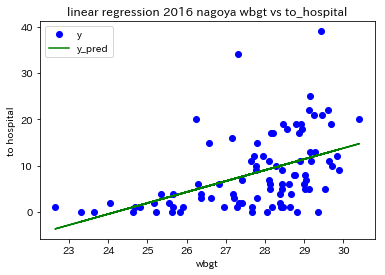

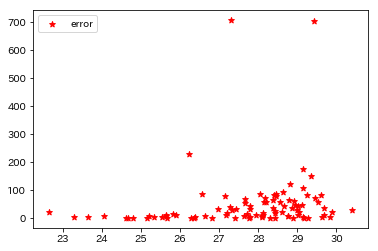

In [46]:
# max wbgt

x=df6wn_1['wbgt'][0:92].values
y= h2016n.hansou.values

X = x.reshape(-1,1)
reg = LinearRegression()
reg.fit(X, y)
print("coef : ", reg.coef_, "intercept : ", reg.intercept_.round(3))

y_pred = reg.predict(X)
error = (y - y_pred)**2

plt.plot(x, y, 'bo')
plt.plot(x, y_pred, marker='', ls="-",c='g')

plt.legend(["y", "y_pred"])
plt.xlabel("wbgt")
plt.ylabel("to hospital")
plt.title("linear regression 2016 nagoya wbgt vs to_hospital")

plt.show()

plt.scatter(x, error, marker="*",c="r")

plt.legend(["error"])
plt.show()

最大気温、日射量、WBGTは各数値が上昇すると搬送者も増加しており、右肩上がりの直線回帰がおよそ当てはまっているように見えるが、一部のデータで誤差が大きい結果となった。下記HP報告によると年齢の影響が無視できないレベルであり、それが反映された誤差である可能性が否定できない（高齢化の進展と個人差）

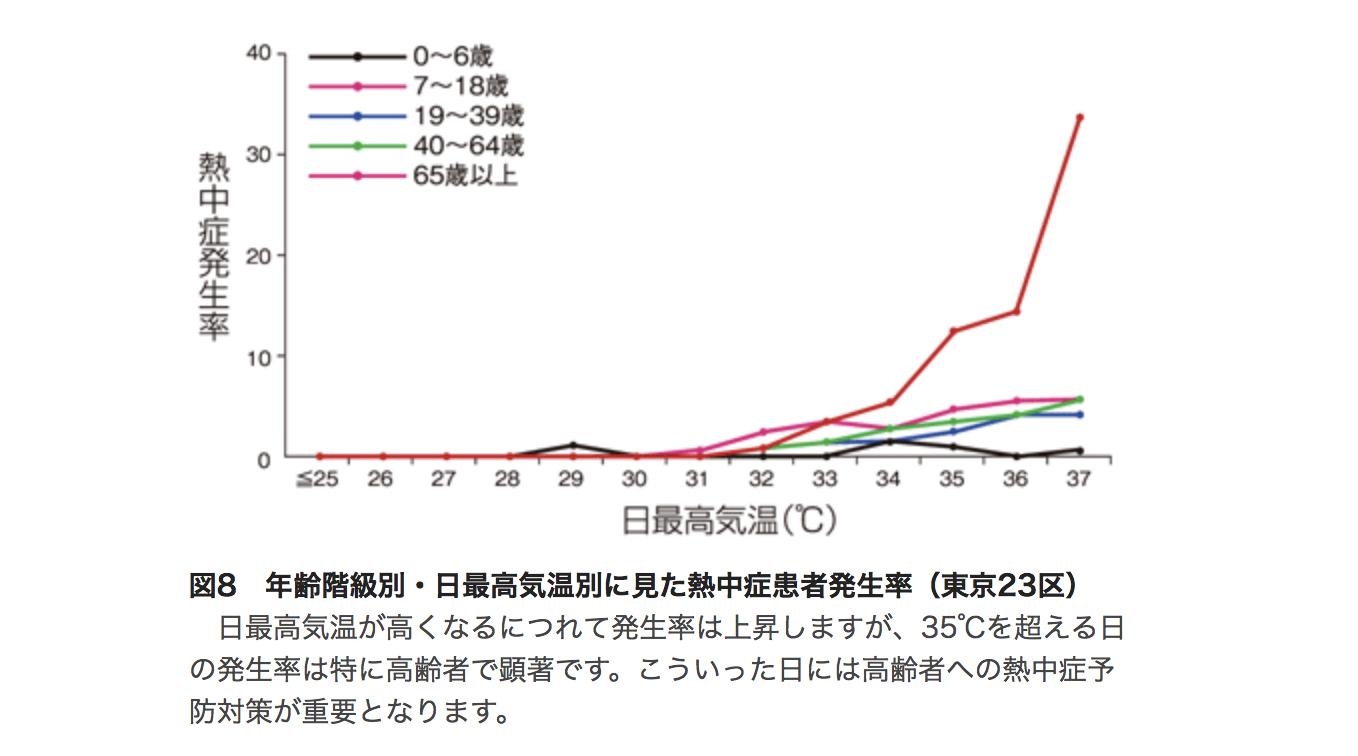
国立環境研究所HP
http://www.nies.go.jp/kanko/kankyogi/32/10-11.html

# RANSAC

RANSAC (RANdom SAmple Consensus) fits a model from random subsets of inliers from the complete data set.

RANSAC is a non-deterministic algorithm producing only a reasonable result with a certain probability, which is dependent on the number of iterations (see max_trials parameter). It is typically used for linear and non-linear regression problems and is especially popular in the fields of photogrammetric computer vision.

The algorithm splits the complete input sample data into a set of inliers, which may be subject to noise, and outliers, which are e.g. caused by erroneous measurements or invalid hypotheses about the data. The resulting model is then estimated only from the determined inliers.

In [47]:
from sklearn.linear_model import LinearRegression,RANSACRegressor
ransac = RANSACRegressor(LinearRegression())

In [48]:
x=df6wn_1['temp'][0:92].values
y= h2016n.hansou.values

In [49]:
X = x.reshape(-1,1)
ransac.fit(X,y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None, loss='absolute_loss',
        max_skips=inf, max_trials=100, min_samples=None, random_state=None,
        residual_metric=None, residual_threshold=None, stop_n_inliers=inf,
        stop_probability=0.99, stop_score=inf)

In [50]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)#反転
outlier_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False, False, False,  True,
       False, False,  True, False,  True, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
        True,  True, False, False, False,  True, False, False, False,
       False, False,  True,  True,  True,  True, False, False, False,
        True, False, False,  True, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True, False, False, False, False,
       False,  True])

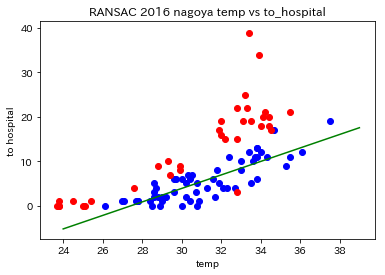

In [51]:
line_X = np.arange(24,40,1)
line_Y = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask],y[inlier_mask],c="blue",marker="o",label="Intliers")#正常値
plt.scatter(X[outlier_mask],y[outlier_mask],c="red",marker="o",label="Outliers")#外れ値
plt.plot(line_X,line_Y,color="green")#予測値

plt.xlabel("temp")
plt.ylabel("to hospital")
plt.title("RANSAC 2016 nagoya temp vs to_hospital")
plt.show()

線形回帰より外れ値の影響を受けにくい

# Support Vector Regression

In [52]:
from sklearn.svm import SVR

In [53]:
# 2016
x=df6wn_1['temp'][0:92].values
y= h2016n.hansou.values

In [54]:
X = x.reshape(-1,1)
svr_lin = SVR(kernel='linear', C=1)
svr_rbf1 = SVR(kernel='rbf', C=10, gamma=0.01)
svr_rbf2 = SVR(kernel='rbf', C=1000, gamma=0.1)
y_lin = svr_lin.fit(X, y).predict(X)
y_rbf1 = svr_rbf1.fit(X, y).predict(X)
y_rbf2 = svr_rbf2.fit(X, y).predict(X)

## plot

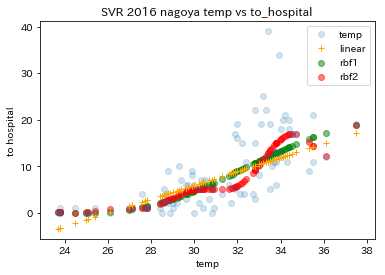

In [55]:
# 学習結果の描画
plt.plot(x, y, 'o', alpha=0.2,label='temp')
plt.plot(x, y_lin, '+', c="orange",label='linear')
plt.scatter(x, y_rbf1, c="g",alpha=0.5,label='rbf1')
plt.scatter(x, y_rbf2, c="r",alpha=0.5,label='rbf2')

plt.xlabel("temp")
plt.ylabel("to hospital")
plt.legend()
plt.title("SVR 2016 nagoya temp vs to_hospital")
plt.xlabel("temp")
plt.ylabel("to hospital")
plt.show()

## Grid Search

In [56]:

from sklearn.preprocessing import MinMaxScaler

X_train = X
y_train = y

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
#X_test  = scaler.transform(X_test)

In [57]:
clf = SVR()

In [58]:
C_range_exp = np.arange(-3.0, 10.0, 1)
C_range = 10**C_range_exp

# gamma range
gamma_range_exp = np.arange(-10.0, 3.0, 1)
gamma_range = 10**gamma_range_exp

epsilon_range = np.arange(-3.0, 3.0, 1)
epsilon_range = 10**epsilon_range

# linear = no gamma  exist
# rbf = gamma exist

param = [{
    'C': C_range,
    'epsilon': epsilon_range,
    'kernel': ['linear']
},
         {
             'C': C_range,
             'gamma': gamma_range,
             'epsilon': epsilon_range,
             'kernel': ['rbf']
         }]

In [335]:
# about 25min (MacBookPro13)

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(clf, param, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 1092 candidates, totalling 3276 fits
[CV] C=0.001, epsilon=0.001, kernel=linear ...........................
[CV] C=0.001, epsilon=0.001, kernel=linear ...........................
[CV] C=0.001, epsilon=0.001, kernel=linear ...........................
[CV] C=0.001, epsilon=0.01, kernel=linear ............................
[CV] ............ C=0.001, epsilon=0.001, kernel=linear, total=   0.0s
[CV] ............ C=0.001, epsilon=0.001, kernel=linear, total=   0.0s
[CV] C=0.001, epsilon=0.01, kernel=linear ............................
[CV] ............ C=0.001, epsilon=0.001, kernel=linear, total=   0.0s
[CV] C=0.001, epsilon=0.01, kernel=linear ............................
[CV] ............. C=0.001, epsilon=0.01, kernel=linear, total=   0.0s
[CV] C=0.001, epsilon=0.1, kernel=linear .............................
[CV] C=0.001, epsilon=0.1, kernel=linear .............................
[CV] ............. C=0.001, epsilon=0.01, kernel=linear, total=   0.0s
[CV] .......

[CV] ............... C=10.0, epsilon=0.1, kernel=linear, total=   0.0s
[CV] C=0.1, epsilon=100.0, kernel=linear .............................
[CV] ............... C=1.0, epsilon=0.01, kernel=linear, total=   0.0s
[CV] .............. C=1.0, epsilon=100.0, kernel=linear, total=   0.0s
[CV] C=10.0, epsilon=1.0, kernel=linear ..............................
[CV] .............. C=0.1, epsilon=100.0, kernel=linear, total=   0.0s
[CV] C=1.0, epsilon=0.001, kernel=linear .............................
[CV] .............. C=1.0, epsilon=0.001, kernel=linear, total=   0.0s
[CV] C=1.0, epsilon=0.001, kernel=linear .............................
[CV] ............... C=10.0, epsilon=1.0, kernel=linear, total=   0.0s
[CV] .............. C=1.0, epsilon=0.001, kernel=linear, total=   0.0s
[CV] C=100.0, epsilon=0.001, kernel=linear ...........................
[CV] ............ C=100.0, epsilon=0.001, kernel=linear, total=   0.0s
[CV] C=100.0, epsilon=0.01, kernel=linear ............................
[CV] .

[CV] ............ C=1000.0, epsilon=0.01, kernel=linear, total=   0.0s
[CV] C=1000.0, epsilon=0.01, kernel=linear ...........................
[CV] C=0.001, epsilon=0.001, gamma=1e-10, kernel=rbf .................
[CV] .. C=0.001, epsilon=0.001, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.001, gamma=1e-09, kernel=rbf .................
[CV] .. C=0.001, epsilon=0.001, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.001, gamma=1e-09, kernel=rbf .................
[CV] .. C=0.001, epsilon=0.001, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] ............ C=1000.0, epsilon=0.01, kernel=linear, total=   0.0s
[CV] C=0.001, epsilon=0.001, gamma=1e-09, kernel=rbf .................
[CV] C=1000.0, epsilon=0.1, kernel=linear ............................
[CV] .. C=0.001, epsilon=0.001, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.001, gamma=1e-08, kernel=rbf .................
[CV] .. C=0.001, epsilon=0.001, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] .

[CV] C=0.001, epsilon=0.001, gamma=100.0, kernel=rbf .................
[CV] ............ C=10000.0, epsilon=0.1, kernel=linear, total=   0.0s
[CV] C=10000.0, epsilon=0.1, kernel=linear ...........................
[CV] .. C=0.001, epsilon=0.001, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.01, gamma=1e-10, kernel=rbf ..................
[CV] ... C=0.001, epsilon=0.01, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.01, gamma=1e-10, kernel=rbf ..................
[CV] ... C=0.001, epsilon=0.01, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] ............ C=10000.0, epsilon=0.1, kernel=linear, total=   0.0s
[CV] C=0.001, epsilon=0.01, gamma=1e-10, kernel=rbf ..................
[CV] C=10000.0, epsilon=0.1, kernel=linear ...........................
[CV] ... C=0.001, epsilon=0.01, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.01, gamma=1e-09, kernel=rbf ..................
[CV] ............ C=10000.0, epsilon=0.1, kernel=linear, total=   0.0s
[CV] C

[CV] C=0.001, epsilon=0.01, gamma=100.0, kernel=rbf ..................
[CV] ... C=0.001, epsilon=0.01, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=1e-10, kernel=rbf ...................
[CV] .... C=0.001, epsilon=0.1, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=1e-10, kernel=rbf ...................
[CV] .... C=0.001, epsilon=0.1, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=1e-10, kernel=rbf ...................
[CV] .... C=0.001, epsilon=0.1, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=1e-09, kernel=rbf ...................
[CV] .... C=0.001, epsilon=0.1, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=1e-09, kernel=rbf ...................
[CV] .... C=0.001, epsilon=0.1, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=1e-09, kernel=rbf ...................
[CV] .... C=0.001, epsilon=0.1, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C

[CV] .... C=0.001, epsilon=1.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=0.1, kernel=rbf .....................
[CV] C=0.001, epsilon=1.0, gamma=100.0, kernel=rbf ...................
[CV] .... C=0.001, epsilon=1.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] ...... C=0.001, epsilon=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=1.0, gamma=100.0, kernel=rbf ...................
[CV] .... C=0.001, epsilon=1.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.1, gamma=1.0, kernel=rbf .....................
[CV] C=0.001, epsilon=10.0, gamma=1e-10, kernel=rbf ..................
[CV] ... C=0.001, epsilon=10.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] ...... C=0.001, epsilon=0.1, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=10.0, gamma=1e-10, kernel=rbf ..................
[CV] C=0.001, epsilon=0.1, gamma=1.0, kernel=rbf .....................
[CV] ... C=0.001, epsilon=10.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] .

[CV] C=0.001, epsilon=10.0, gamma=0.01, kernel=rbf ...................
[CV] .... C=0.001, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] .... C=0.001, epsilon=10.0, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=100.0, gamma=1.0, kernel=rbf ...................
[CV] C=0.001, epsilon=10.0, gamma=0.01, kernel=rbf ...................
[CV] .... C=0.001, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] .... C=0.001, epsilon=10.0, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=100.0, gamma=1.0, kernel=rbf ...................
[CV] C=0.001, epsilon=10.0, gamma=0.1, kernel=rbf ....................
[CV] .... C=0.001, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] ..... C=0.001, epsilon=10.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=100.0, gamma=10.0, kernel=rbf ..................
[CV] C=0.001, epsilon=10.0, gamma=0.1, kernel=rbf ....................
[CV] ..... C=0.001, epsilon=10.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] .

[CV] C=0.001, epsilon=100.0, gamma=1e-07, kernel=rbf .................
[CV] .. C=0.001, epsilon=100.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=100.0, gamma=1e-06, kernel=rbf .................
[CV] .. C=0.001, epsilon=100.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=100.0, gamma=1e-06, kernel=rbf .................
[CV] ........ C=1000000.0, epsilon=0.001, kernel=linear, total=   0.4s
[CV] .. C=0.001, epsilon=100.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=0.001, kernel=linear .......................
[CV] C=0.001, epsilon=100.0, gamma=1e-06, kernel=rbf .................
[CV] .. C=0.001, epsilon=100.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=100.0, gamma=1e-05, kernel=rbf .................
[CV] .. C=0.001, epsilon=100.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=100.0, gamma=1e-05, kernel=rbf .................
[CV] .. C=0.001, epsilon=100.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C

[CV] .... C=0.01, epsilon=0.01, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=0.1, gamma=1e-05, kernel=rbf ....................
[CV] C=0.01, epsilon=0.01, gamma=1e-08, kernel=rbf ...................
[CV] ..... C=0.01, epsilon=0.1, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=0.1, gamma=1e-05, kernel=rbf ....................
[CV] ..... C=0.01, epsilon=0.1, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] .... C=0.01, epsilon=0.01, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=0.1, gamma=1e-05, kernel=rbf ....................
[CV] C=0.01, epsilon=0.01, gamma=1e-08, kernel=rbf ...................
[CV] ..... C=0.01, epsilon=0.1, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=0.1, gamma=0.0001, kernel=rbf ...................
[CV] .... C=0.01, epsilon=0.01, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] .... C=0.01, epsilon=0.1, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=0.01, gamma=1e-08, kernel=rbf ...................
[CV] C

[CV] C=0.01, epsilon=1.0, gamma=1e-09, kernel=rbf ....................
[CV] ..... C=0.01, epsilon=0.01, gamma=10.0, kernel=rbf, total=   0.0s
[CV] ..... C=0.01, epsilon=1.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=0.01, gamma=100.0, kernel=rbf ...................
[CV] C=0.01, epsilon=1.0, gamma=1e-09, kernel=rbf ....................
[CV] .... C=0.01, epsilon=0.01, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=10.0, gamma=1e-08, kernel=rbf ...................
[CV] ..... C=0.01, epsilon=1.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] .... C=0.01, epsilon=10.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=1.0, gamma=1e-08, kernel=rbf ....................
[CV] C=0.01, epsilon=10.0, gamma=1e-07, kernel=rbf ...................
[CV] ..... C=0.01, epsilon=1.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=1.0, gamma=1e-08, kernel=rbf ....................
[CV] .... C=0.01, epsilon=10.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C

[CV] ..... C=0.01, epsilon=10.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=1.0, gamma=10.0, kernel=rbf .....................
[CV] C=0.01, epsilon=10.0, gamma=10.0, kernel=rbf ....................
[CV] ..... C=0.01, epsilon=10.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] ...... C=0.01, epsilon=1.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=10.0, gamma=100.0, kernel=rbf ...................
[CV] C=0.01, epsilon=1.0, gamma=10.0, kernel=rbf .....................
[CV] .... C=0.01, epsilon=10.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] ...... C=0.01, epsilon=1.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=10.0, gamma=100.0, kernel=rbf ...................
[CV] C=0.01, epsilon=1.0, gamma=100.0, kernel=rbf ....................
[CV] .... C=0.01, epsilon=10.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] ..... C=0.01, epsilon=1.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=10.0, gamma=100.0, kernel=rbf ...................
[CV] C

[CV] C=0.01, epsilon=100.0, gamma=0.1, kernel=rbf ....................
[CV] ...... C=0.1, epsilon=0.001, gamma=1.0, kernel=rbf, total=   0.0s
[CV] ..... C=0.01, epsilon=100.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=100.0, gamma=0.1, kernel=rbf ....................
[CV] C=0.1, epsilon=0.001, gamma=1.0, kernel=rbf .....................
[CV] ..... C=0.01, epsilon=100.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] ...... C=0.1, epsilon=0.001, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=100.0, gamma=0.1, kernel=rbf ....................
[CV] C=0.1, epsilon=0.001, gamma=1.0, kernel=rbf .....................
[CV] ..... C=0.01, epsilon=100.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] ...... C=0.1, epsilon=0.001, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=0.01, epsilon=100.0, gamma=1.0, kernel=rbf ....................
[CV] C=0.1, epsilon=0.001, gamma=10.0, kernel=rbf ....................
[CV] ..... C=0.01, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] .

[CV] C=0.1, epsilon=0.01, gamma=1e-05, kernel=rbf ....................
[CV] ...... C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf .....................
[CV] ..... C=0.1, epsilon=0.01, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf ...................
[CV] ...... C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf .....................
[CV] .... C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] ...... C=0.1, epsilon=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf ...................
[CV] C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf ......................
[CV] .... C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] ....... C=0.1, epsilon=0.01, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=0.01, gamma=0.0001, kernel=rbf ...................
[CV] .

[CV] ...... C=0.1, epsilon=0.1, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=1.0, gamma=1e-06, kernel=rbf .....................
[CV] C=0.1, epsilon=0.1, gamma=1e-05, kernel=rbf .....................
[CV] ...... C=0.1, epsilon=1.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] ...... C=0.1, epsilon=0.1, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=0.1, gamma=1e-05, kernel=rbf .....................
[CV] C=0.1, epsilon=1.0, gamma=1e-06, kernel=rbf .....................
[CV] ...... C=0.1, epsilon=1.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] ...... C=0.1, epsilon=0.1, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=0.1, gamma=1e-05, kernel=rbf .....................
[CV] C=0.1, epsilon=1.0, gamma=1e-06, kernel=rbf .....................
[CV] ...... C=0.1, epsilon=0.1, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] ...... C=0.1, epsilon=1.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=0.1, gamma=0.0001, kernel=rbf ....................
[CV] C

[CV] C=0.1, epsilon=10.0, gamma=1e-08, kernel=rbf ....................
[CV] ..... C=0.1, epsilon=10.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=10.0, gamma=1e-08, kernel=rbf ....................
[CV] ..... C=0.1, epsilon=10.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=10.0, gamma=1e-08, kernel=rbf ....................
[CV] ..... C=0.1, epsilon=10.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=10.0, gamma=1e-07, kernel=rbf ....................
[CV] ..... C=0.1, epsilon=10.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=10.0, gamma=1e-07, kernel=rbf ....................
[CV] ..... C=0.1, epsilon=10.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] .... C=0.1, epsilon=100.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=0.1, epsilon=100.0, gamma=1e-07, kernel=rbf ...................
[CV] C=0.1, epsilon=10.0, gamma=1e-07, kernel=rbf ....................
[CV] .... C=0.1, epsilon=100.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] .

[CV] .... C=0.1, epsilon=100.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.001, gamma=1e-10, kernel=rbf ...................
[CV] C=0.1, epsilon=10.0, gamma=10.0, kernel=rbf .....................
[CV] .... C=1.0, epsilon=0.001, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] ...... C=0.1, epsilon=10.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.001, gamma=1e-10, kernel=rbf ...................
[CV] C=0.1, epsilon=10.0, gamma=100.0, kernel=rbf ....................
[CV] ..... C=0.1, epsilon=10.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] .... C=1.0, epsilon=0.001, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.001, gamma=1e-10, kernel=rbf ...................
[CV] C=0.1, epsilon=10.0, gamma=100.0, kernel=rbf ....................
[CV] .... C=1.0, epsilon=0.001, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] ..... C=0.1, epsilon=10.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.001, gamma=1e-09, kernel=rbf ...................
[CV] C

[CV] ...... C=1.0, epsilon=0.001, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.01, gamma=10.0, kernel=rbf .....................
[CV] C=1.0, epsilon=0.001, gamma=1.0, kernel=rbf .....................
[CV] ...... C=1.0, epsilon=0.01, gamma=10.0, kernel=rbf, total=   0.0s
[CV] ...... C=1.0, epsilon=0.001, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.01, gamma=10.0, kernel=rbf .....................
[CV] C=1.0, epsilon=0.001, gamma=1.0, kernel=rbf .....................
[CV] ...... C=1.0, epsilon=0.01, gamma=10.0, kernel=rbf, total=   0.0s
[CV] ...... C=1.0, epsilon=0.001, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.01, gamma=100.0, kernel=rbf ....................
[CV] C=1.0, epsilon=0.001, gamma=1.0, kernel=rbf .....................
[CV] ..... C=1.0, epsilon=0.01, gamma=100.0, kernel=rbf, total=   0.0s
[CV] ...... C=1.0, epsilon=0.001, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.001, gamma=10.0, kernel=rbf ....................
[CV] C

[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:    2.8s


[CV] ..... C=1.0, epsilon=0.01, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] ...... C=1.0, epsilon=0.1, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.1, gamma=1e-09, kernel=rbf .....................
[CV] C=1.0, epsilon=0.01, gamma=1e-10, kernel=rbf ....................
[CV] ...... C=1.0, epsilon=0.1, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] ..... C=1.0, epsilon=0.01, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.01, gamma=1e-09, kernel=rbf ....................
[CV] C=1.0, epsilon=0.1, gamma=1e-09, kernel=rbf .....................
[CV] ...... C=1.0, epsilon=0.1, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] ..... C=1.0, epsilon=0.01, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.01, gamma=1e-09, kernel=rbf ....................
[CV] C=1.0, epsilon=0.1, gamma=1e-09, kernel=rbf .....................
[CV] ..... C=1.0, epsilon=0.01, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.01, gamma=1e-09, kernel=rbf ....................
[CV] .

[CV] ...... C=1.0, epsilon=1.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] ....... C=1.0, epsilon=0.1, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=0.1, gamma=10.0, kernel=rbf ......................
[CV] C=1.0, epsilon=1.0, gamma=100.0, kernel=rbf .....................
[CV] ...... C=1.0, epsilon=1.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] ....... C=1.0, epsilon=0.1, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=10.0, gamma=1e-10, kernel=rbf ....................
[CV] C=1.0, epsilon=0.1, gamma=10.0, kernel=rbf ......................
[CV] ..... C=1.0, epsilon=10.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] ....... C=1.0, epsilon=0.1, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=10.0, gamma=1e-10, kernel=rbf ....................
[CV] C=1.0, epsilon=0.1, gamma=100.0, kernel=rbf .....................
[CV] ..... C=1.0, epsilon=10.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=10.0, gamma=1e-10, kernel=rbf ....................
[CV] .

[CV] ....... C=1.0, epsilon=10.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] ...... C=1.0, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=10.0, gamma=0.1, kernel=rbf ......................
[CV] C=1.0, epsilon=100.0, gamma=10.0, kernel=rbf ....................
[CV] ..... C=1.0, epsilon=100.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] ....... C=1.0, epsilon=10.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=100.0, gamma=10.0, kernel=rbf ....................
[CV] ..... C=1.0, epsilon=100.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=10.0, gamma=0.1, kernel=rbf ......................
[CV] C=1.0, epsilon=100.0, gamma=10.0, kernel=rbf ....................
[CV] ....... C=1.0, epsilon=10.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] ..... C=1.0, epsilon=100.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=10.0, gamma=1.0, kernel=rbf ......................
[CV] C=1.0, epsilon=100.0, gamma=100.0, kernel=rbf ...................
[CV] .

[CV] C=1.0, epsilon=100.0, gamma=0.0001, kernel=rbf ..................
[CV] C=10.0, epsilon=0.001, gamma=0.0001, kernel=rbf .................
[CV] ... C=1.0, epsilon=100.0, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=100.0, gamma=0.001, kernel=rbf ...................
[CV] .. C=10.0, epsilon=0.001, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] .... C=1.0, epsilon=100.0, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=0.001, gamma=0.001, kernel=rbf ..................
[CV] C=1.0, epsilon=100.0, gamma=0.001, kernel=rbf ...................
[CV] ... C=10.0, epsilon=0.001, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=0.001, gamma=0.001, kernel=rbf ..................
[CV] .... C=1.0, epsilon=100.0, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1.0, epsilon=100.0, gamma=0.001, kernel=rbf ...................
[CV] ... C=10.0, epsilon=0.001, gamma=0.001, kernel=rbf, total=   0.0s
[CV] .... C=1.0, epsilon=100.0, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C

[CV] .... C=10.0, epsilon=0.01, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] ..... C=10.0, epsilon=0.1, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=0.01, gamma=1e-06, kernel=rbf ...................
[CV] C=10.0, epsilon=0.1, gamma=1e-05, kernel=rbf ....................
[CV] .... C=10.0, epsilon=0.01, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] ..... C=10.0, epsilon=0.1, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=0.01, gamma=1e-05, kernel=rbf ...................
[CV] C=10.0, epsilon=0.1, gamma=0.0001, kernel=rbf ...................
[CV] .... C=10.0, epsilon=0.01, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=0.01, gamma=1e-05, kernel=rbf ...................
[CV] .... C=10.0, epsilon=0.1, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=0.1, gamma=0.0001, kernel=rbf ...................
[CV] .... C=10.0, epsilon=0.01, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=0.01, gamma=1e-05, kernel=rbf ...................
[CV] .

[CV] C=10.0, epsilon=1.0, gamma=1e-07, kernel=rbf ....................
[CV] C=10.0, epsilon=10.0, gamma=1e-07, kernel=rbf ...................
[CV] ..... C=10.0, epsilon=1.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] .... C=10.0, epsilon=10.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=1.0, gamma=1e-07, kernel=rbf ....................
[CV] C=10.0, epsilon=10.0, gamma=1e-07, kernel=rbf ...................
[CV] ..... C=10.0, epsilon=1.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=1.0, gamma=1e-06, kernel=rbf ....................
[CV] .... C=10.0, epsilon=10.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=10.0, gamma=1e-06, kernel=rbf ...................
[CV] ..... C=10.0, epsilon=1.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] .... C=10.0, epsilon=10.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=1.0, gamma=1e-06, kernel=rbf ....................
[CV] C=10.0, epsilon=10.0, gamma=1e-06, kernel=rbf ...................
[CV] .

[CV] ... C=10.0, epsilon=100.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=100.0, gamma=1e-10, kernel=rbf ..................
[CV] ..... C=10.0, epsilon=1.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=1.0, gamma=100.0, kernel=rbf ....................
[CV] ... C=10.0, epsilon=100.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=100.0, gamma=1e-09, kernel=rbf ..................
[CV] ..... C=10.0, epsilon=1.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=10.0, gamma=1e-10, kernel=rbf ...................
[CV] .... C=10.0, epsilon=10.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=10.0, gamma=1e-10, kernel=rbf ...................
[CV] ... C=10.0, epsilon=100.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=100.0, gamma=1e-09, kernel=rbf ..................
[CV] ... C=10.0, epsilon=100.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=10.0, epsilon=100.0, gamma=1e-09, kernel=rbf ..................
[CV] .

[CV] C=10.0, epsilon=100.0, gamma=1.0, kernel=rbf ....................
[CV] C=100.0, epsilon=0.001, gamma=100.0, kernel=rbf .................
[CV] ..... C=10.0, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] .. C=100.0, epsilon=0.001, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=0.001, gamma=100.0, kernel=rbf .................
[CV] C=10.0, epsilon=100.0, gamma=1.0, kernel=rbf ....................
[CV] .. C=100.0, epsilon=0.001, gamma=100.0, kernel=rbf, total=   0.0s
[CV] ..... C=10.0, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=0.01, gamma=1e-10, kernel=rbf ..................
[CV] C=10.0, epsilon=100.0, gamma=10.0, kernel=rbf ...................
[CV] .... C=10.0, epsilon=100.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] ... C=100.0, epsilon=0.01, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=0.01, gamma=1e-10, kernel=rbf ..................
[CV] C=10.0, epsilon=100.0, gamma=10.0, kernel=rbf ...................
[CV] .

[CV] C=100.0, epsilon=0.01, gamma=0.01, kernel=rbf ...................
[CV] C=100.0, epsilon=0.01, gamma=0.1, kernel=rbf ....................
[CV] .... C=100.0, epsilon=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] ..... C=100.0, epsilon=0.01, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=0.1, gamma=1.0, kernel=rbf .....................
[CV] C=100.0, epsilon=0.01, gamma=1.0, kernel=rbf ....................
[CV] ...... C=100.0, epsilon=0.1, gamma=1.0, kernel=rbf, total=   0.0s
[CV] ..... C=100.0, epsilon=0.01, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=0.1, gamma=1.0, kernel=rbf .....................
[CV] C=100.0, epsilon=0.01, gamma=1.0, kernel=rbf ....................
[CV] ..... C=100.0, epsilon=0.01, gamma=1.0, kernel=rbf, total=   0.0s
[CV] ...... C=100.0, epsilon=0.1, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=0.01, gamma=1.0, kernel=rbf ....................
[CV] C=100.0, epsilon=0.1, gamma=1.0, kernel=rbf .....................
[CV] .

[CV] ... C=100.0, epsilon=0.1, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=0.1, gamma=0.001, kernel=rbf ...................
[CV] .... C=100.0, epsilon=1.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=1.0, gamma=0.0001, kernel=rbf ..................
[CV] .... C=100.0, epsilon=0.1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=0.1, gamma=0.001, kernel=rbf ...................
[CV] ... C=100.0, epsilon=1.0, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] .... C=100.0, epsilon=0.1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=1.0, gamma=0.0001, kernel=rbf ..................
[CV] C=100.0, epsilon=0.1, gamma=0.001, kernel=rbf ...................
[CV] .... C=100.0, epsilon=0.1, gamma=0.001, kernel=rbf, total=   0.0s
[CV] ... C=100.0, epsilon=1.0, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=1.0, gamma=0.0001, kernel=rbf ..................
[CV] C=100.0, epsilon=0.1, gamma=0.01, kernel=rbf ....................
[CV] .

[CV] C=100.0, epsilon=100.0, gamma=1e-06, kernel=rbf .................
[CV] C=100.0, epsilon=10.0, gamma=1e-05, kernel=rbf ..................
[CV] .. C=100.0, epsilon=100.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] ... C=100.0, epsilon=10.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=10.0, gamma=1e-05, kernel=rbf ..................
[CV] C=100.0, epsilon=100.0, gamma=1e-06, kernel=rbf .................
[CV] ... C=100.0, epsilon=10.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] .. C=100.0, epsilon=100.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=10.0, gamma=1e-05, kernel=rbf ..................
[CV] C=100.0, epsilon=100.0, gamma=1e-05, kernel=rbf .................
[CV] .. C=100.0, epsilon=100.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] ... C=100.0, epsilon=10.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=100.0, epsilon=10.0, gamma=0.0001, kernel=rbf .................
[CV] C=100.0, epsilon=100.0, gamma=1e-05, kernel=rbf .................
[CV] .

[CV] . C=1000.0, epsilon=0.001, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] . C=1000.0, epsilon=0.001, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.001, gamma=1e-10, kernel=rbf ................
[CV] C=1000.0, epsilon=0.001, gamma=1e-07, kernel=rbf ................
[CV] . C=1000.0, epsilon=0.001, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] . C=1000.0, epsilon=0.001, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.001, gamma=1e-09, kernel=rbf ................
[CV] C=1000.0, epsilon=0.001, gamma=1e-06, kernel=rbf ................
[CV] . C=1000.0, epsilon=0.001, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] . C=1000.0, epsilon=0.001, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.001, gamma=1e-09, kernel=rbf ................
[CV] C=1000.0, epsilon=0.001, gamma=1e-06, kernel=rbf ................
[CV] . C=1000.0, epsilon=0.001, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] . C=1000.0, epsilon=0.001, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C

[CV] C=1000.0, epsilon=0.1, gamma=1e-10, kernel=rbf ..................
[CV] C=1000.0, epsilon=0.001, gamma=100.0, kernel=rbf ................
[CV] ... C=1000.0, epsilon=0.1, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.1, gamma=1e-10, kernel=rbf ..................
[CV] ... C=1000.0, epsilon=0.1, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.1, gamma=1e-10, kernel=rbf ..................
[CV] . C=1000.0, epsilon=0.001, gamma=100.0, kernel=rbf, total=   0.0s
[CV] ... C=1000.0, epsilon=0.1, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.001, gamma=100.0, kernel=rbf ................
[CV] C=1000.0, epsilon=0.1, gamma=1e-09, kernel=rbf ..................
[CV] . C=1000.0, epsilon=0.001, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.001, gamma=100.0, kernel=rbf ................
[CV] . C=1000.0, epsilon=0.001, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.01, gamma=1e-10, kernel=rbf .................
[CV] .

[CV] ..... C=1000.0, epsilon=1.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=1.0, gamma=10.0, kernel=rbf ...................
[CV] ..... C=1000.0, epsilon=0.1, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.1, gamma=10.0, kernel=rbf ...................
[CV] .... C=1000.0, epsilon=1.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=1.0, gamma=10.0, kernel=rbf ...................
[CV] .... C=1000.0, epsilon=0.1, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.1, gamma=10.0, kernel=rbf ...................
[CV] .... C=1000.0, epsilon=1.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=1.0, gamma=10.0, kernel=rbf ...................
[CV] .... C=1000.0, epsilon=0.1, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=0.1, gamma=10.0, kernel=rbf ...................
[CV] .... C=1000.0, epsilon=1.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=1.0, gamma=100.0, kernel=rbf ..................
[CV] .

[CV] .. C=1000.0, epsilon=1.0, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] ... C=1000.0, epsilon=10.0, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=10.0, gamma=0.01, kernel=rbf ..................
[CV] ... C=1000.0, epsilon=10.0, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=10.0, gamma=0.1, kernel=rbf ...................
[CV] .... C=1000.0, epsilon=10.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=10.0, gamma=0.01, kernel=rbf ..................
[CV] C=1000.0, epsilon=10.0, gamma=0.1, kernel=rbf ...................
[CV] ... C=1000.0, epsilon=10.0, gamma=0.01, kernel=rbf, total=   0.0s
[CV] .... C=1000.0, epsilon=10.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=10.0, gamma=0.1, kernel=rbf ...................
[CV] .... C=1000.0, epsilon=10.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=100.0, gamma=1.0, kernel=rbf ..................
[CV] C=1000.0, epsilon=10.0, gamma=1.0, kernel=rbf ...................
[CV] .

[CV] C=1000.0, epsilon=100.0, gamma=1e-05, kernel=rbf ................
[CV] C=10000.0, epsilon=0.001, gamma=0.0001, kernel=rbf ..............
[CV] . C=1000.0, epsilon=100.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV]  C=10000.0, epsilon=0.001, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=100.0, gamma=1e-05, kernel=rbf ................
[CV] C=10000.0, epsilon=0.001, gamma=0.001, kernel=rbf ...............
[CV] . C=1000.0, epsilon=100.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=100.0, gamma=1e-05, kernel=rbf ................
[CV]  C=10000.0, epsilon=0.001, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=0.001, gamma=0.001, kernel=rbf ...............
[CV] . C=1000.0, epsilon=100.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=1000.0, epsilon=100.0, gamma=0.0001, kernel=rbf ...............
[CV]  C=10000.0, epsilon=0.001, gamma=0.001, kernel=rbf, total=   0.0s
[CV]  C=1000.0, epsilon=100.0, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] 

[CV] ... C=10000.0, epsilon=0.1, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=0.1, gamma=0.01, kernel=rbf ..................
[CV] ... C=10000.0, epsilon=0.1, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=0.1, gamma=0.01, kernel=rbf ..................
[CV] ... C=10000.0, epsilon=0.1, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=0.1, gamma=0.1, kernel=rbf ...................
[CV] .... C=10000.0, epsilon=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=0.1, gamma=0.1, kernel=rbf ...................
[CV] .... C=10000.0, epsilon=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=0.1, gamma=0.1, kernel=rbf ...................
[CV] .... C=10000.0, epsilon=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=0.1, gamma=1.0, kernel=rbf ...................
[CV] .... C=10000.0, epsilon=0.1, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=10000.0, epsilon=0.1, gamma=1.0, kernel=rbf ...................
[CV] .

[CV] .. C=10000.0, epsilon=1.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=1.0, gamma=1e-08, kernel=rbf .................
[CV] .. C=10000.0, epsilon=1.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=1.0, gamma=1e-08, kernel=rbf .................
[CV] .. C=10000.0, epsilon=1.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=1.0, gamma=1e-08, kernel=rbf .................
[CV] .. C=10000.0, epsilon=1.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=1.0, gamma=1e-07, kernel=rbf .................
[CV] .. C=10000.0, epsilon=1.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=1.0, gamma=1e-07, kernel=rbf .................
[CV] . C=10000.0, epsilon=0.01, gamma=100.0, kernel=rbf, total=   0.1s
[CV] C=10000.0, epsilon=0.01, gamma=100.0, kernel=rbf ................
[CV] .. C=10000.0, epsilon=1.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=1.0, gamma=1e-07, kernel=rbf .................
[CV] .

[CV] ... C=10000.0, epsilon=10.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=10.0, gamma=10.0, kernel=rbf .................
[CV] .. C=10000.0, epsilon=10.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=10.0, gamma=10.0, kernel=rbf .................
[CV] .. C=10000.0, epsilon=10.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=10.0, gamma=10.0, kernel=rbf .................
[CV] .. C=10000.0, epsilon=10.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=10.0, gamma=100.0, kernel=rbf ................
[CV] . C=10000.0, epsilon=10.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=10.0, gamma=100.0, kernel=rbf ................
[CV] . C=10000.0, epsilon=10.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=10.0, gamma=100.0, kernel=rbf ................
[CV] . C=10000.0, epsilon=10.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=100.0, gamma=1e-10, kernel=rbf ...............
[CV] .

[CV] .. C=10000.0, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=100.0, gamma=10.0, kernel=rbf ................
[CV] . C=10000.0, epsilon=100.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=100.0, gamma=10.0, kernel=rbf ................
[CV] . C=10000.0, epsilon=100.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=100.0, gamma=10.0, kernel=rbf ................
[CV] . C=10000.0, epsilon=100.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=100.0, gamma=100.0, kernel=rbf ...............
[CV]  C=10000.0, epsilon=100.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=100.0, gamma=100.0, kernel=rbf ...............
[CV]  C=10000.0, epsilon=100.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=10000.0, epsilon=100.0, gamma=100.0, kernel=rbf ...............
[CV]  C=10000.0, epsilon=100.0, gamma=100.0, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.001, gamma=1e-10, kernel=rbf ..............
[CV]  

[CV]  C=100000.0, epsilon=0.01, gamma=100.0, kernel=rbf, total=   0.2s
[CV] C=100000.0, epsilon=0.1, gamma=1e-10, kernel=rbf ................
[CV] . C=100000.0, epsilon=0.1, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.1, gamma=1e-10, kernel=rbf ................
[CV] . C=100000.0, epsilon=0.1, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.1, gamma=1e-10, kernel=rbf ................
[CV] . C=100000.0, epsilon=0.1, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.1, gamma=1e-09, kernel=rbf ................
[CV] . C=100000.0, epsilon=0.1, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.1, gamma=1e-09, kernel=rbf ................
[CV] . C=100000.0, epsilon=0.1, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.1, gamma=1e-09, kernel=rbf ................
[CV] . C=100000.0, epsilon=0.1, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.1, gamma=1e-08, kernel=rbf ................
[CV] .

[CV]  C=100000.0, epsilon=0.01, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.01, gamma=0.001, kernel=rbf ...............
[CV]  C=100000.0, epsilon=0.01, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.01, gamma=0.01, kernel=rbf ................
[CV] . C=100000.0, epsilon=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.01, gamma=0.01, kernel=rbf ................
[CV] . C=100000.0, epsilon=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=0.01, gamma=0.01, kernel=rbf ................
[CV] . C=100000.0, epsilon=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=1.0, gamma=100.0, kernel=rbf ................
[CV] .. C=100000.0, epsilon=0.1, gamma=10.0, kernel=rbf, total=   0.2s
[CV] C=100000.0, epsilon=0.1, gamma=10.0, kernel=rbf .................
[CV] . C=100000.0, epsilon=1.0, gamma=100.0, kernel=rbf, total=   0.4s
[CV] C=100000.0, epsilon=1.0, gamma=100.0, kernel=rbf ................
[CV] .

[CV]  C=100000.0, epsilon=100.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=100.0, gamma=1e-07, kernel=rbf ..............
[CV]  C=100000.0, epsilon=100.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=100.0, gamma=1e-07, kernel=rbf ..............
[CV]  C=100000.0, epsilon=100.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=100.0, gamma=1e-06, kernel=rbf ..............
[CV]  C=100000.0, epsilon=100.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=100.0, gamma=1e-06, kernel=rbf ..............
[CV]  C=100000.0, epsilon=100.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=100.0, gamma=1e-06, kernel=rbf ..............
[CV]  C=100000.0, epsilon=100.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=100.0, gamma=1e-05, kernel=rbf ..............
[CV]  C=100000.0, epsilon=100.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=100000.0, epsilon=100.0, gamma=1e-05, kernel=rbf ..............

[CV] C=100000.0, epsilon=0.1, gamma=100.0, kernel=rbf ................
[CV] ....... C=10000000.0, epsilon=0.001, kernel=linear, total=   4.3s
[CV] C=10000000.0, epsilon=0.001, kernel=linear ......................
[CV]  C=1000000.0, epsilon=0.001, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=1000000.0, epsilon=0.001, gamma=0.1, kernel=rbf ...............
[CV]  C=1000000.0, epsilon=0.001, gamma=0.1, kernel=rbf, total=   0.2s
[CV] C=1000000.0, epsilon=0.001, gamma=0.1, kernel=rbf ...............
[CV]  C=1000000.0, epsilon=0.001, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=0.001, gamma=1.0, kernel=rbf ...............
[CV] . C=100000.0, epsilon=0.1, gamma=100.0, kernel=rbf, total=   0.6s
[CV] C=100000.0, epsilon=0.1, gamma=100.0, kernel=rbf ................
[CV]  C=1000000.0, epsilon=0.001, gamma=1.0, kernel=rbf, total=   0.3s
[CV] C=1000000.0, epsilon=0.001, gamma=1.0, kernel=rbf ...............
[CV] . C=100000.0, epsilon=0.1, gamma=100.0, kernel=rbf, total=   0.2s
[CV] C

[CV] C=1000000.0, epsilon=0.01, gamma=0.01, kernel=rbf ...............
[CV]  C=1000000.0, epsilon=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=0.01, gamma=0.01, kernel=rbf ...............
[CV]  C=1000000.0, epsilon=0.01, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=0.01, gamma=0.1, kernel=rbf ................
[CV] . C=1000000.0, epsilon=0.01, gamma=0.1, kernel=rbf, total=   0.2s
[CV] C=1000000.0, epsilon=0.01, gamma=0.1, kernel=rbf ................
[CV] . C=1000000.0, epsilon=0.01, gamma=0.1, kernel=rbf, total=   0.2s
[CV] C=1000000.0, epsilon=0.01, gamma=0.1, kernel=rbf ................
[CV] . C=1000000.0, epsilon=0.01, gamma=0.1, kernel=rbf, total=   0.1s
[CV] C=1000000.0, epsilon=0.01, gamma=1.0, kernel=rbf ................
[CV] . C=1000000.0, epsilon=0.01, gamma=1.0, kernel=rbf, total=   0.2s
[CV] C=1000000.0, epsilon=0.01, gamma=1.0, kernel=rbf ................
[CV] . C=1000000.0, epsilon=0.01, gamma=1.0, kernel=rbf, total=   0.3s
[CV] C

[CV] C=1000000.0, epsilon=0.1, gamma=10.0, kernel=rbf ................
[CV] ......... C=10000000.0, epsilon=0.1, kernel=linear, total=   2.9s
[CV] C=10000000.0, epsilon=0.1, kernel=linear ........................
[CV] . C=1000000.0, epsilon=0.1, gamma=10.0, kernel=rbf, total=   1.4s
[CV] C=1000000.0, epsilon=0.1, gamma=10.0, kernel=rbf ................
[CV] ...... C=100000000.0, epsilon=0.001, kernel=linear, total=  22.5s
[CV] C=100000000.0, epsilon=0.001, kernel=linear .....................
[CV] . C=1000000.0, epsilon=0.1, gamma=10.0, kernel=rbf, total=   2.0s
[CV] C=1000000.0, epsilon=0.1, gamma=100.0, kernel=rbf ...............
[CV]  C=1000000.0, epsilon=0.001, gamma=100.0, kernel=rbf, total=   4.9s
[CV] C=1000000.0, epsilon=0.001, gamma=100.0, kernel=rbf .............
[CV]  C=1000000.0, epsilon=0.001, gamma=100.0, kernel=rbf, total=   0.5s
[CV] C=1000000.0, epsilon=0.01, gamma=1e-10, kernel=rbf ..............
[CV]  C=1000000.0, epsilon=0.01, gamma=1e-10, kernel=rbf, total=   0.0s
[

[CV] C=100000000.0, epsilon=0.01, kernel=linear ......................
[CV] ......... C=10000000.0, epsilon=1.0, kernel=linear, total=   4.6s
[CV] C=10000000.0, epsilon=1.0, kernel=linear ........................
[CV]  C=1000000.0, epsilon=1.0, gamma=100.0, kernel=rbf, total=   5.8s
[CV] C=1000000.0, epsilon=1.0, gamma=100.0, kernel=rbf ...............
[CV] ......... C=10000000.0, epsilon=1.0, kernel=linear, total=   1.4s
[CV] C=10000000.0, epsilon=1.0, kernel=linear ........................
[CV] ......... C=10000000.0, epsilon=1.0, kernel=linear, total=   1.0s
[CV] C=1000000.0, epsilon=10.0, gamma=1e-08, kernel=rbf ..............
[CV]  C=1000000.0, epsilon=10.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=10.0, gamma=1e-08, kernel=rbf ..............
[CV]  C=1000000.0, epsilon=10.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=10.0, gamma=1e-08, kernel=rbf ..............
[CV]  C=1000000.0, epsilon=10.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV

[CV]  C=1000000.0, epsilon=100.0, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=100.0, gamma=0.0001, kernel=rbf ............
[CV]  C=1000000.0, epsilon=100.0, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=100.0, gamma=0.001, kernel=rbf .............
[CV]  C=1000000.0, epsilon=100.0, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=100.0, gamma=0.001, kernel=rbf .............
[CV]  C=1000000.0, epsilon=100.0, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=100.0, gamma=0.001, kernel=rbf .............
[CV]  C=1000000.0, epsilon=100.0, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=100.0, gamma=0.01, kernel=rbf ..............
[CV]  C=1000000.0, epsilon=100.0, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=100.0, gamma=0.01, kernel=rbf ..............
[CV]  C=1000000.0, epsilon=100.0, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=100.0, gamma=0.01, kernel=rbf .......

[CV]  C=1000000.0, epsilon=10.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=10.0, gamma=1e-09, kernel=rbf ..............
[CV]  C=1000000.0, epsilon=10.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=1000000.0, epsilon=10.0, gamma=1e-09, kernel=rbf ..............
[CV]  C=1000000.0, epsilon=10.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.01, gamma=1e-07, kernel=rbf .............
[CV]  C=10000000.0, epsilon=0.01, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.01, gamma=1e-07, kernel=rbf .............
[CV]  C=10000000.0, epsilon=0.01, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.01, gamma=1e-06, kernel=rbf .............
[CV]  C=10000000.0, epsilon=0.01, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.01, gamma=1e-06, kernel=rbf .............
[CV]  C=10000000.0, epsilon=0.01, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.01, gamma=1e-06, kernel=rbf .........

[CV] C=10000000.0, epsilon=0.1, gamma=1e-09, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=0.1, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.1, gamma=1e-08, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=0.1, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.1, gamma=1e-08, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=0.1, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.1, gamma=1e-08, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=0.1, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.1, gamma=1e-07, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=0.1, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.1, gamma=1e-07, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=0.1, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=0.1, gamma=1e-07, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=0.1, gamma=1e-07, kernel=rbf, total=   0.0s

[CV]  C=10000000.0, epsilon=10.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=10.0, gamma=1e-08, kernel=rbf .............
[CV]  C=10000000.0, epsilon=10.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=10.0, gamma=1e-07, kernel=rbf .............
[CV]  C=10000000.0, epsilon=10.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=10.0, gamma=1e-07, kernel=rbf .............
[CV]  C=10000000.0, epsilon=10.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=10.0, gamma=1e-07, kernel=rbf .............
[CV]  C=10000000.0, epsilon=10.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf .............
[CV]  C=10000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf .............
[CV]  C=10000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf ......

[CV]  C=10000000.0, epsilon=100.0, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=100.0, gamma=0.01, kernel=rbf .............
[CV]  C=10000000.0, epsilon=100.0, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=100.0, gamma=0.1, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=100.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=100.0, gamma=0.1, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=100.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=100.0, gamma=0.1, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=100.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=100.0, gamma=1.0, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=100.0, gamma=1.0, kernel=rbf ..............
[CV]  C=10000000.0, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=10000000.0, epsilon=100.0, gamma=1.0, kernel=rbf ............

[CV]  C=10000000.0, epsilon=1.0, gamma=100.0, kernel=rbf, total=  36.2s
[CV] C=10000000.0, epsilon=1.0, gamma=100.0, kernel=rbf ..............
[CV] ........ C=100000000.0, epsilon=1.0, kernel=linear, total=  50.0s
[CV] C=100000000.0, epsilon=1.0, kernel=linear .......................
[CV] ........ C=100000000.0, epsilon=1.0, kernel=linear, total=   3.6s
[CV] C=100000000.0, epsilon=10.0, kernel=linear ......................
[CV] ....... C=100000000.0, epsilon=10.0, kernel=linear, total=   0.0s
[CV] C=100000000.0, epsilon=10.0, kernel=linear ......................
[CV] ....... C=100000000.0, epsilon=10.0, kernel=linear, total=   0.5s
[CV] C=100000000.0, epsilon=10.0, kernel=linear ......................
[CV] ....... C=100000000.0, epsilon=10.0, kernel=linear, total=   0.2s
[CV] C=100000000.0, epsilon=100.0, kernel=linear .....................
[CV] ...... C=100000000.0, epsilon=100.0, kernel=linear, total=   0.0s
[CV] C=100000000.0, epsilon=100.0, kernel=linear .....................
[CV] 

[CV]  C=100000000.0, epsilon=0.01, gamma=0.1, kernel=rbf, total=   0.8s
[CV] C=100000000.0, epsilon=0.01, gamma=0.1, kernel=rbf ..............
[CV]  C=100000000.0, epsilon=0.01, gamma=0.1, kernel=rbf, total=   0.5s
[CV] C=100000000.0, epsilon=0.01, gamma=1.0, kernel=rbf ..............
[CV]  C=100000000.0, epsilon=0.01, gamma=1.0, kernel=rbf, total=   4.3s
[CV] C=100000000.0, epsilon=0.01, gamma=1.0, kernel=rbf ..............
[CV]  C=100000000.0, epsilon=0.01, gamma=1.0, kernel=rbf, total=   4.9s
[CV] C=100000000.0, epsilon=0.01, gamma=1.0, kernel=rbf ..............
[CV] ..... C=1000000000.0, epsilon=0.001, kernel=linear, total=  23.4s
[CV] C=1000000000.0, epsilon=0.01, kernel=linear .....................
[CV] ...... C=1000000000.0, epsilon=0.01, kernel=linear, total=   4.9s
[CV] C=1000000000.0, epsilon=0.01, kernel=linear .....................
[CV]  C=100000000.0, epsilon=0.01, gamma=1.0, kernel=rbf, total=   8.7s
[CV] C=100000000.0, epsilon=0.01, gamma=10.0, kernel=rbf .............
[

[CV] C=1000000000.0, epsilon=100.0, kernel=linear ....................
[CV] ..... C=1000000000.0, epsilon=100.0, kernel=linear, total=   0.0s
[CV] C=1000000000.0, epsilon=100.0, kernel=linear ....................
[CV] ..... C=1000000000.0, epsilon=100.0, kernel=linear, total=   0.0s
[CV] C=1000000000.0, epsilon=100.0, kernel=linear ....................
[CV] ..... C=1000000000.0, epsilon=100.0, kernel=linear, total=   0.0s
[CV] C=0.001, epsilon=0.001, gamma=1e-10, kernel=rbf .................
[CV] .. C=0.001, epsilon=0.001, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=0.001, epsilon=0.001, gamma=1e-10, kernel=rbf .................
[CV] .. C=0.001, epsilon=0.001, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=0.1, gamma=100.0, kernel=rbf .............
[CV]  C=100000000.0, epsilon=0.1, gamma=10.0, kernel=rbf, total=  23.3s
[CV] C=100000000.0, epsilon=0.1, gamma=100.0, kernel=rbf .............
[CV]  C=100000000.0, epsilon=0.01, gamma=100.0, kernel=rbf, total= 1.2min
[C

[Parallel(n_jobs=-1)]: Done 2930 tasks      | elapsed:  9.9min


[CV]  C=100000000.0, epsilon=1.0, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=1.0, gamma=0.001, kernel=rbf .............
[CV]  C=100000000.0, epsilon=1.0, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=1.0, gamma=0.01, kernel=rbf ..............
[CV]  C=100000000.0, epsilon=1.0, gamma=0.01, kernel=rbf, total=   0.1s
[CV] C=100000000.0, epsilon=1.0, gamma=0.01, kernel=rbf ..............
[CV]  C=100000000.0, epsilon=1.0, gamma=0.01, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=1.0, gamma=0.01, kernel=rbf ..............
[CV]  C=100000000.0, epsilon=1.0, gamma=0.01, kernel=rbf, total=   0.2s
[CV] C=100000000.0, epsilon=1.0, gamma=0.1, kernel=rbf ...............
[CV]  C=100000000.0, epsilon=1.0, gamma=0.1, kernel=rbf, total=   0.5s
[CV] C=100000000.0, epsilon=1.0, gamma=0.1, kernel=rbf ...............
[CV]  C=100000000.0, epsilon=1.0, gamma=0.1, kernel=rbf, total=   1.2s
[CV] C=100000000.0, epsilon=1.0, gamma=0.1, kernel=rbf ...............

[CV]  C=100000000.0, epsilon=100.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=100.0, gamma=1e-10, kernel=rbf ...........
[CV]  C=100000000.0, epsilon=100.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=100.0, gamma=1e-09, kernel=rbf ...........
[CV]  C=100000000.0, epsilon=100.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=100.0, gamma=1e-09, kernel=rbf ...........
[CV]  C=100000000.0, epsilon=100.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=100.0, gamma=1e-09, kernel=rbf ...........
[CV]  C=100000000.0, epsilon=100.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=100.0, gamma=1e-08, kernel=rbf ...........
[CV]  C=100000000.0, epsilon=100.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=100.0, gamma=1e-08, kernel=rbf ...........
[CV]  C=100000000.0, epsilon=100.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=100000000.0, epsilon=100.0, gamma=1e-08, k

[CV] C=1000000000.0, epsilon=0.001, gamma=0.0001, kernel=rbf .........
[CV]  C=1000000000.0, epsilon=0.001, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=0.001, gamma=0.0001, kernel=rbf .........
[CV]  C=1000000000.0, epsilon=0.001, gamma=0.0001, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=0.001, gamma=0.001, kernel=rbf ..........
[CV]  C=1000000000.0, epsilon=0.001, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=0.001, gamma=0.001, kernel=rbf ..........
[CV]  C=1000000000.0, epsilon=0.001, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=0.001, gamma=0.001, kernel=rbf ..........
[CV]  C=1000000000.0, epsilon=0.001, gamma=0.001, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=0.001, gamma=0.01, kernel=rbf ...........
[CV]  C=1000000000.0, epsilon=0.001, gamma=0.01, kernel=rbf, total=   0.2s
[CV] C=1000000000.0, epsilon=0.001, gamma=0.01, kernel=rbf ...........
[CV]  C=1000000000.0, epsilon=0.001, gamma=0.0

[CV]  C=1000000000.0, epsilon=1.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=1.0, gamma=1e-10, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=1.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=1.0, gamma=1e-10, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=1.0, gamma=1e-10, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=1.0, gamma=1e-09, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=1.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=1.0, gamma=1e-09, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=1.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=1.0, gamma=1e-09, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=1.0, gamma=1e-09, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=1.0, gamma=1e-08, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=1.0, gamma=1e-08, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=1.0, gamma=1e-08, kernel=rb

[CV]  C=1000000000.0, epsilon=10.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=10.0, gamma=1e-07, kernel=rbf ...........
[CV]  C=1000000000.0, epsilon=10.0, gamma=1e-07, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf ...........
[CV]  C=1000000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf ...........
[CV]  C=1000000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf ...........
[CV]  C=1000000000.0, epsilon=10.0, gamma=1e-06, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=10.0, gamma=1e-05, kernel=rbf ...........
[CV]  C=1000000000.0, epsilon=10.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=10.0, gamma=1e-05, kernel=rbf ...........
[CV]  C=1000000000.0, epsilon=10.0, gamma=1e-05, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=10.0, gamma=1e-05, k

[CV] C=1000000000.0, epsilon=100.0, gamma=0.1, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=100.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=100.0, gamma=0.1, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=100.0, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=100.0, gamma=1.0, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=100.0, gamma=1.0, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=100.0, gamma=1.0, kernel=rbf ............
[CV]  C=1000000000.0, epsilon=100.0, gamma=1.0, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=100.0, gamma=10.0, kernel=rbf ...........
[CV]  C=1000000000.0, epsilon=100.0, gamma=10.0, kernel=rbf, total=   0.0s
[CV] C=1000000000.0, epsilon=100.0, gamma=10.0, kernel=rbf ...........
[CV]  C=1000000000.0, epsilon=100.0, gamma=10.0, kernel=rb

[Parallel(n_jobs=-1)]: Done 3276 out of 3276 | elapsed: 24.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09]), 'epsilon': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'kernel': ['linear']}, {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1....1, 1.e+02]), 'epsilon': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

## best param plot in 2016

In [336]:
gs.best_params_,gs.best_score_,gs.best_estimator_

({'C': 100000000.0, 'epsilon': 0.001, 'kernel': 'linear'},
 0.09035718804839307,
 SVR(C=100000000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.001,
   gamma='auto', kernel='linear', max_iter=-1, shrinking=True, tol=0.001,
   verbose=False))

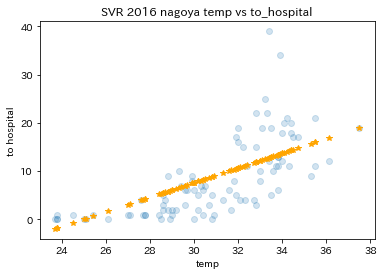

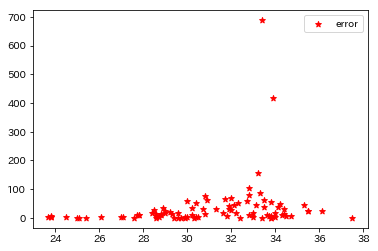

In [59]:
X = x.reshape(-1,1)

svr = SVR(C=100000000,epsilon=0.001,kernel='linear')

plt.plot(x, y, 'o', alpha=0.2)
y_pred = svr.fit(X, y).predict(X)
plt.plot(x, y_pred, '*', c="orange")

plt.xlabel("temp")
plt.ylabel("to hospital")
plt.title("SVR 2016 nagoya temp vs to_hospital")
plt.xlabel("temp")
plt.ylabel("to hospital")
plt.show()

error = (y - y_pred)**2

plt.legend(["y", "y_pred"])
plt.scatter(x, error, marker="*",c="r")
plt.legend(["error"])

plt.show()

In [60]:
error[error.argsort(axis=0)[::-1]][:3]

array([688.14347639, 419.12396579, 157.16701983])

In [61]:
df6wn_1.iloc[error.argsort(axis=0)[::-1][:3]]

place  temp  wind_speed  solar_radiation  relative_humidity  \
2016-07-03  nagoya  33.4         5.8             2.85               93.0   
2016-07-05  nagoya  33.9         6.8             3.37               83.0   
2016-07-02  nagoya  33.2         4.1             3.25               83.0   

                 wbgt  
2016-07-03  29.438349  
2016-07-05  27.303186  
2016-07-02  29.138763

## 2017 plot

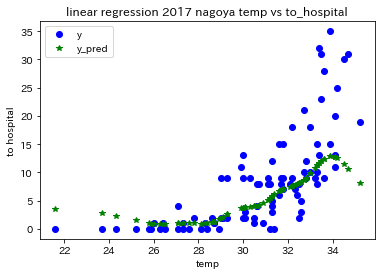

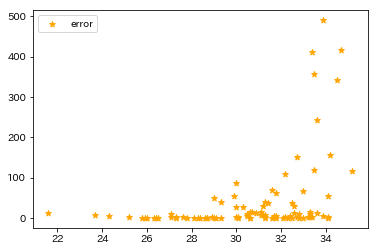

In [62]:
# 2017
x_test=df7wn_1['temp'][0:92].values
y= h2017n.hansou.values

X = x_test.reshape(-1,1)
reg = SVR()
reg.fit(X, y)

y_pred = reg.predict(X)

error2 = (y - y_pred)**2

plt.plot(x_test, y, 'bo')
plt.plot(x_test, y_pred, 'g*')

plt.legend(["y", "y_pred"])
plt.xlabel("temp")
plt.ylabel("to hospital")
plt.title("linear regression 2017 nagoya temp vs to_hospital")

plt.show()

plt.scatter(x_test, error2,  marker='*', c="orange")

plt.legend(["error"])
plt.show()

## 2018 plot

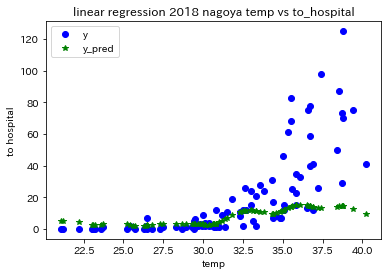

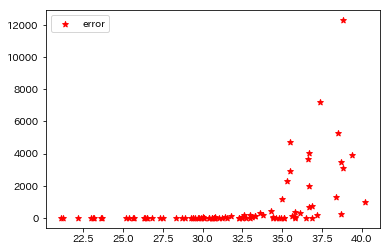

In [63]:
# 2018 
x_test=df8wn_1['temp'][0:92].values
y= h2018n.hansou.values

X = x_test.reshape(-1,1)
reg = SVR()
reg.fit(X, y)
#print("coef : ", reg.coef_, "intercept : ", reg.intercept_.round(3))

y_pred = reg.predict(X)

error3 = (y - y_pred)**2

plt.plot(x_test, y, 'bo')
plt.plot(x_test, y_pred, 'g*')

plt.legend(["y", "y_pred"])
plt.xlabel("temp")
plt.ylabel("to hospital")
plt.title("linear regression 2018 nagoya temp vs to_hospital")

plt.show()

plt.scatter(x_test, error3, marker="*",c="r")

plt.legend(["error"])
plt.show()

In [64]:
error2[error2.argsort(axis=0)[::-1]][:3]

array([490.13764862, 415.53357853, 410.74440012])

In [65]:
df8wn_1.iloc[error2.argsort(axis=0)[::-1][:3]]

place  temp  wind_speed  solar_radiation  relative_humidity  \
2018-07-03  nagoya  30.4         6.1             2.73               86.0   
2018-07-16  nagoya  37.4         5.3             3.12               76.0   
2018-08-10  nagoya  35.8         5.5             2.37               74.0   

                 wbgt  
2018-07-03  26.586826  
2018-07-16  30.930194  
2018-08-10  29.695600

・誤差大の傾向は上記LinearRegressionと同様と想定（高齢化等）  
・SVRだと直線回帰で追従できない範囲まで対応できていることが分かるが、高温時は追従しきれていない

# 疎構造

北海道から沖縄まで距離が離れた地点の気温データの相関を確認してみる

In [36]:
from sklearn.covariance import GraphLasso
import sklearn
from sklearn.preprocessing import StandardScaler
from IPython.display import Image, display

import pydot # for node plot with graphviz

## 地点データ追加

In [24]:
t_tko=df6wt['temp'].values
t_ngo=df6wn['temp'].values
t_osk=df6wo['temp'].values

t_sap=df2016[df2016['place']=='sapporo']['temp'].values
t_nha=df2016[df2016['place']=='naha']['temp'].values
t_fuk=df2016[df2016['place']=='fukuoka']['temp'].values
t_kof=df2016[df2016['place']=='kofu']['temp'].values

t = pd.DataFrame(
    [t_sap, t_tko, t_kof, t_ngo, t_osk, t_fuk, t_nha],
    index=['sapporo', 'tokyo', 'kofu', 'nagoya', 'osaka', 'fukuoka', 'naha'])

In [25]:
t

0     1     2     3     4     5     6     7     8     9     ...   \
sapporo  18.4  18.3  18.2  18.1  18.2  19.2  20.9  22.7  24.3  25.1  ...    
tokyo    22.6  22.3  22.3  22.7  22.7  23.2  24.2  24.8  25.6  26.1  ...    
kofu     22.6  22.9  22.5  22.4  22.4  22.7  23.3  24.6  26.2  28.7  ...    
nagoya   23.8  23.5  23.2  22.7  22.8  23.3  24.8  27.0  28.2  28.1  ...    
osaka    24.4  24.4  24.1  24.0  24.0  23.7  25.1  25.5  27.1  28.4  ...    
fukuoka  24.3  24.3  24.4  23.9  23.9  24.2  25.6  27.2  28.1  28.7  ...    
naha     28.6  28.4  28.2  28.1  28.1  28.1  28.9  29.9  30.9  31.5  ...    

         2198  2199  2200  2201  2202  2203  2204  2205  2206  2207  
sapporo  21.7  21.1  19.6  18.9  18.2  18.0  16.7  16.2  16.7  16.2  
tokyo    23.3  22.7  22.1  21.9  21.5  21.3  22.0  21.5  21.8  21.5  
kofu     23.5  22.6  21.6  20.9  20.6  20.3  20.1  20.0  19.8  19.5  
nagoya   23.4  23.4  22.6  22.1  21.9  21.1  21.0  20.7  20.9  20.8  
osaka    26.3  26.3  26.3  25.3  24.3  22.6  21.7  21.8  21.8  21.8  
fukuoka  26.9  25.5  25.7  25.4  22.8  22.3  22.3  22.4  22.1  22.6  
naha     31.4  30.8  29.9  29.1  28.9  28.9  28.2  28.3  28.3  28.1  

[7 rows x 2208 columns]

In [26]:
t.T.isnull().sum()

sapporo    0
tokyo      0
kofu       0
nagoya     0
osaka      0
fukuoka    0
naha       0
dtype: int64

In [27]:
X=t.T

# 標準化
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

## 気温のヒストグラムと散布図 2016

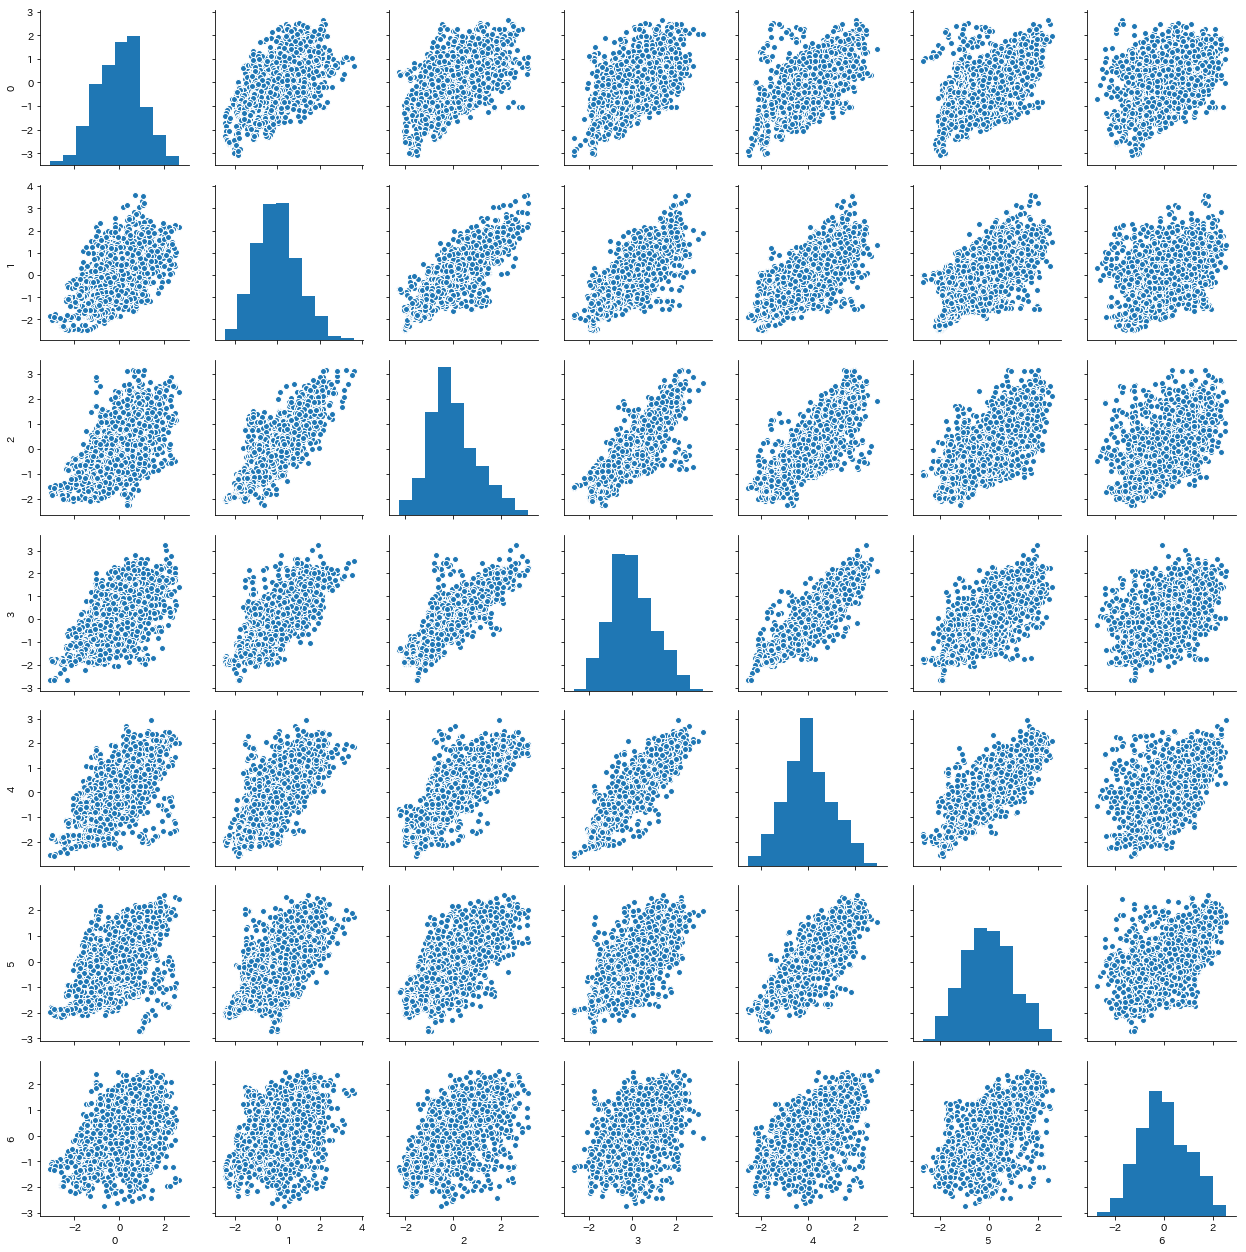

In [28]:
sns.pairplot(pd.DataFrame(X))

In [29]:
# parametars
alpha = 0.01 # L１正則化パラメーター
M = X.shape[1]
label = t.index

## GraphicalLasso Model in sklearn

In [30]:
model = GraphLasso(
    alpha=alpha, max_iter=100, verbose=True, assume_centered=True)
model.fit(X)
cov_ = model.covariance_  # 分散共分散行列
prec_ = model.precision_  # 精度行列

[graph_lasso] Iteration   0, cost  2.68e+01, dual gap 6.460e-02
[graph_lasso] Iteration   1, cost  2.68e+01, dual gap 8.094e-05


## HeatMap 1st

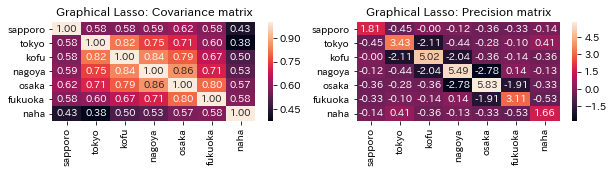

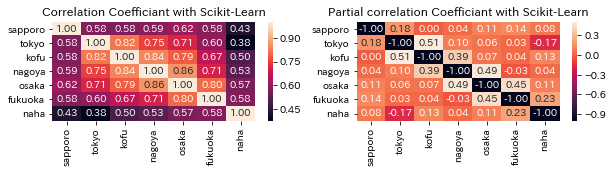

In [31]:
# Scikit LearnのGraphical Lassoの結果表示

plt.figure(figsize=(10, 4))
ax = plt.subplot(221)
sns.heatmap(
    cov_, annot=cov_, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Graphical Lasso: Covariance matrix")

ax = plt.subplot(222)
sns.heatmap(
    prec_,
    annot=prec_,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Graphical Lasso: Precision matrix")

# 相関行列の算出
cor = np.empty_like(cov_)
for i in range(M):
    for j in range(M):
        cor[i, j] = cov_[i, j] / np.sqrt(cov_[i, i] * cov_[j, j])

# 偏相関行列の算出
rho = np.empty_like(prec_)
for i in range(M):
    for j in range(M):
        rho[i, j] = -prec_[i, j] / np.sqrt(prec_[i, i] * prec_[j, j])

plt.figure(figsize=(10, 4))

ax = plt.subplot(223)
sns.heatmap(
    pd.DataFrame(cor),
    annot=cor,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Correlation Coefficiant with Scikit-Learn")


ax = plt.subplot(224)
sns.heatmap(
    pd.DataFrame(rho),
    annot=rho,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Partial correlation Coefficiant with Scikit-Learn")
plt.show()

In [32]:
# Display graph without saving using pydot
def viewPydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

In [33]:
def Disp_Gaussian_Graphical_Model(model,feature_names):
    pre_ = model.precision_ 
     
    pre_zero=pre_-np.diag(np.diag(pre_))
     
    g = pydot.Dot(graph_type='graph')
    df = pd.DataFrame(index=feature_names.tolist(),
                      columns=feature_names.tolist(), 
                      data=pre_zero.tolist())
     
    #ノードを追加
    for c in df.columns:
        node = pydot.Node(c)
        g.add_node(node)
    #エッジを追加    
    for i in df.index:
        for c in df.columns:
            if c>=i:

                if abs(df.loc[i, c]) > 0.3:
                    edge = pydot.Edge(g.get_node(i)[0], g.get_node(c)[0],
                                      penwidth=5*abs(df.loc[i, c]))
                    edge.set_label('{:.1f}'.format(df.loc[i, c]))
                    g.add_edge(edge)
     
    nodeList = g.get_node_list()
    num_edges=np.sum(abs(pre_zero) > 0.3, axis=0)
    max_num_edges=max(np.amax(num_edges),1)
    for i in range(len(df.index)):        
        node = nodeList[i]
        # H S Vの順 Sを変更
        color=str(0)+" "+str(num_edges[i]/max_num_edges)+" "+str(1)
        node.set_color("black") #nodeの輪郭の色
        node.set_fillcolor(color) #nodeの中身の色
        node.set_style('filled')  
    viewPydot(g)

## plot node model 1st

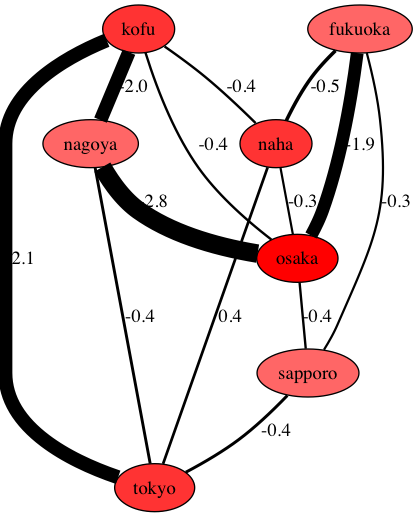

In [34]:
# alpha = 0.01
Disp_Gaussian_Graphical_Model(model,feature_names=label)

## Cross Validation 

In [37]:
edge_model = sklearn.covariance.GraphLassoCV()
# X = StandardScaler().fit_transform(X)
edge_model.fit(X)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

## HeatMap 2nd(after CV)

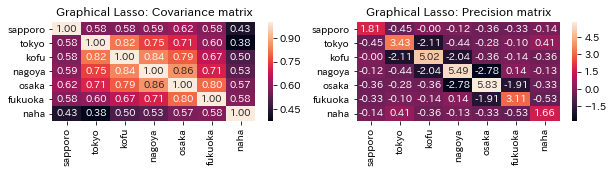

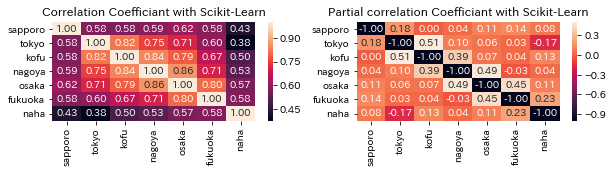

In [38]:
plt.figure(figsize=(10, 4))
ax = plt.subplot(221)
sns.heatmap(
    cov_, annot=cov_, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Graphical Lasso: Covariance matrix")

ax = plt.subplot(222)
sns.heatmap(
    prec_,
    annot=prec_,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Graphical Lasso: Precision matrix")

# 相関行列の算出
cor = np.empty_like(cov_)
for i in range(M):
    for j in range(M):
        cor[i, j] = cov_[i, j] / np.sqrt(cov_[i, i] * cov_[j, j])

# 偏相関行列の算出
rho = np.empty_like(prec_)
for i in range(M):
    for j in range(M):
        rho[i, j] = -prec_[i, j] / np.sqrt(prec_[i, i] * prec_[j, j])

plt.figure(figsize=(10, 4))

ax = plt.subplot(223)
sns.heatmap(
    pd.DataFrame(cor),
    annot=cor,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Correlation Coefficiant with Scikit-Learn")

ax = plt.subplot(224)
sns.heatmap(
    pd.DataFrame(rho),
    annot=rho,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Partial correlation Coefficiant with Scikit-Learn")
plt.show()

## plot node model 2nd(after CV)

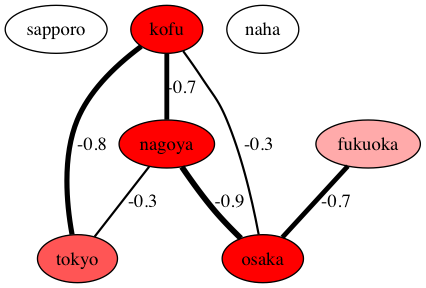

In [39]:
# 2016
Disp_Gaussian_Graphical_Model(edge_model,feature_names=label)

alpha = : 0.1903164320590931


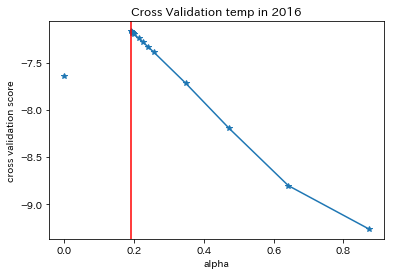

In [62]:
# cross validation for selected alpha 2016

plt.title("Cross Validation temp in 2016")
plt.plot(edge_model.cv_alphas_,np.mean(edge_model.grid_scores_,axis=1),'*-')
plt.xlabel('alpha')
print("alpha = :",edge_model.alpha_)
plt.ylabel('cross validation score')
plt.axvline(edge_model.alpha_,c='r')
plt.show()

## 2017 temp data

In [41]:
#2017
t_tko = df7wt['temp'].values
t_ngo = df7wn['temp'].values
t_osk = df7wo['temp'].values

t_sap = df2017[df2017['place'] == 'sapporo']['temp'].values
t_nha = df2017[df2017['place'] == 'naha']['temp'].values
t_fuk = df2017[df2017['place'] == 'fukuoka']['temp'].values
t_kof = df2017[df2017['place'] == 'kofu']['temp'].values

t1 = pd.DataFrame(
    [t_sap, t_tko, t_kof, t_ngo, t_osk, t_fuk, t_nha],
    index=['sapporo', 'tokyo', 'kofu', 'nagoya', 'osaka', 'fukuoka', 'naha'])

In [42]:
t1.T.isnull().sum()

sapporo     0
tokyo      10
kofu        0
nagoya      0
osaka       0
fukuoka     0
naha        0
dtype: int64

In [43]:
t1=t1.dropna(axis=1)

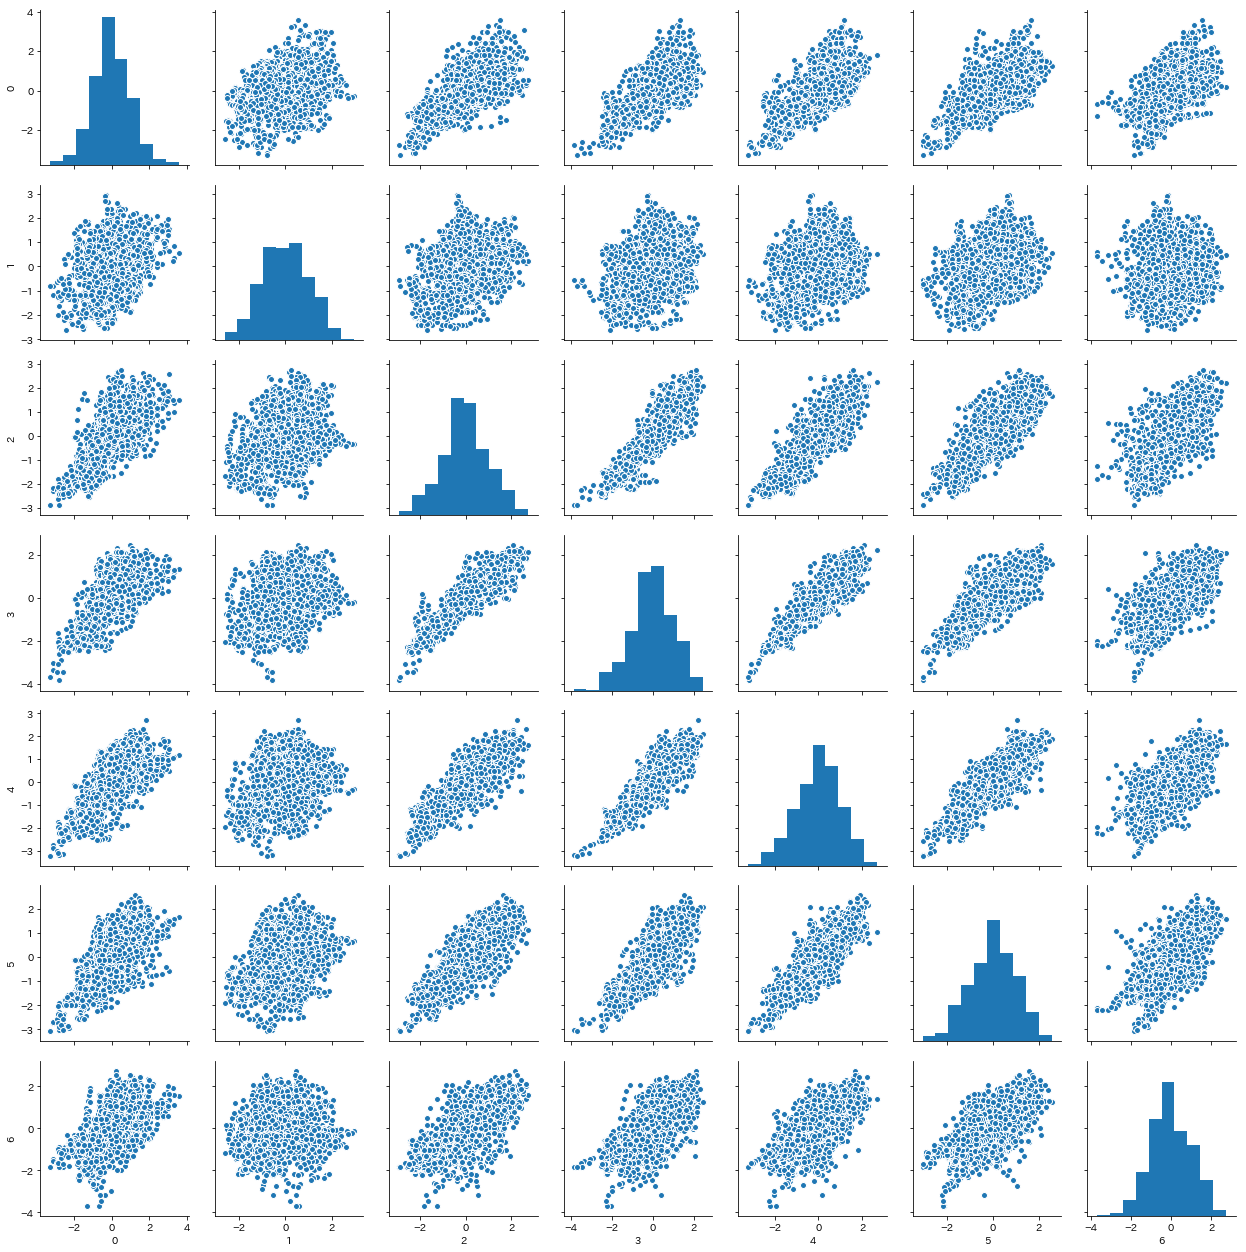

In [46]:
X1=t1.T

# 標準化
sc = StandardScaler()
sc.fit(X1)
X1 = sc.transform(X)
sns.pairplot(pd.DataFrame(X1))

## Cross Validation 2017

In [53]:
M = X1.shape[1]
label = t1.index
edge_model1 = sklearn.covariance.GraphLassoCV()
edge_model1.fit(X1)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

## plot node model 2016 vs 2017

2017


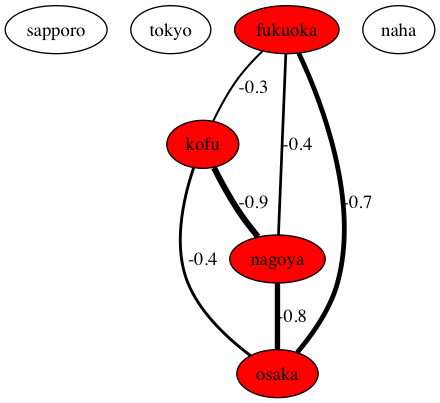

2016


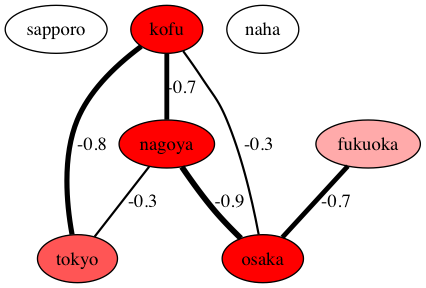

In [54]:
print("2017")
Disp_Gaussian_Graphical_Model(edge_model1, feature_names=label) #2017
print("2016")
Disp_Gaussian_Graphical_Model(edge_model,  feature_names=label)  #2016

２０１７年は、２０１６年と異なり、東京、甲府、名古屋、大阪、福岡のグループから東京が外れた結果となった。

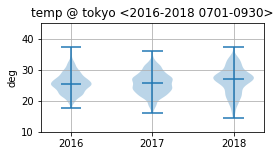　実際に気温分布も他地域と傾向が異なっており異常と判断できる余地があると考える

## HeatMap 2017

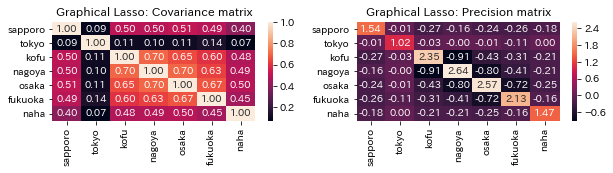

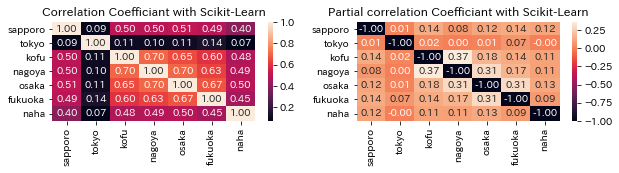

In [55]:
cov_ = edge_model1.covariance_  
prec_ = edge_model1.precision_  

plt.figure(figsize=(10, 4))
ax = plt.subplot(221)
sns.heatmap(
    cov_, annot=cov_, fmt='0.2f', ax=ax, xticklabels=label, yticklabels=label)
plt.title("Graphical Lasso: Covariance matrix")

ax = plt.subplot(222)
sns.heatmap(
    prec_,
    annot=prec_,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Graphical Lasso: Precision matrix")

# 相関行列の算出
cor = np.empty_like(cov_)
for i in range(M):
    for j in range(M):
        cor[i, j] = cov_[i, j] / np.sqrt(cov_[i, i] * cov_[j, j])

# 偏相関行列の算出
rho = np.empty_like(prec_)
for i in range(M):
    for j in range(M):
        rho[i, j] = -prec_[i, j] / np.sqrt(prec_[i, i] * prec_[j, j])

plt.figure(figsize=(10, 4))

ax = plt.subplot(223)
sns.heatmap(
    pd.DataFrame(cor),
    annot=cor,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Correlation Coefficiant with Scikit-Learn")


ax = plt.subplot(224)
sns.heatmap(
    pd.DataFrame(rho),
    annot=rho,
    fmt='0.2f',
    ax=ax,
    xticklabels=label,
    yticklabels=label)
plt.title("Partial correlation Coefficiant with Scikit-Learn")
plt.show()

alpha = : 0.1960835892377037


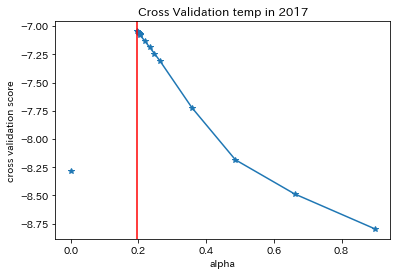

In [61]:
plt.title("Cross Validation temp in 2017")
plt.plot(edge_model1.cv_alphas_, np.mean(edge_model1.grid_scores_, axis=1),
         '*-')
plt.xlabel('alpha')
print("alpha = :", edge_model1.alpha_)
plt.ylabel('cross validation score')
plt.axvline(edge_model1.alpha_,c='r')
plt.show()

# ガウス過程

In [70]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process import kernels as sk_kern

##  2016 temp train data

In [141]:
# 2016
df6wn_1=df6wn.groupby(df6wn.index.date).max()
y_train=df6wn_1['temp'][0:92].values
x_train= np.arange(1,93)

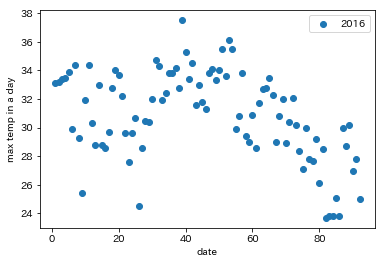

In [142]:
plt.scatter(x_train, y_train, label="2016")
plt.ylabel("max temp in a day")
plt.xlabel("date")
plt.legend()
plt.show()

## rbf kernel

In [143]:
kern = sk_kern.RBF(length_scale=.1)

In [144]:
kernel = sk_kern.RBF(1.0, (1e-3, 1e3)) + sk_kern.ConstantKernel(
    1.0, (1e-3, 1e3)) + sk_kern.WhiteKernel()

clf = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-1,
    optimizer="fmin_l_bfgs_b",
    n_restarts_optimizer=50,
    normalize_y=True)

In [145]:
clf.fit(x_train.reshape(-1,1), y_train)

GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
             kernel=RBF(length_scale=1) + 1**2 + WhiteKernel(noise_level=1),
             n_restarts_optimizer=50, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [146]:
clf.kernel_

RBF(length_scale=10.3) + 0.0316**2 + WhiteKernel(noise_level=4.92)

## prediction

In [155]:
x_test = np.linspace(1,120, 300).reshape(-1, 1) # +1month
pred_mean, pred_std= clf.predict(x_test, return_std=True)

In [158]:
Z_95 = 1.96  # 95% confidence
Z_995 = 2.576 # 99.7 % confidence

def plot_result(x_test, mean, std):
    plt.plot(x_test[:, 0], mean, color="C0", label="predict mean")
    plt.fill_between(
        x_test[:, 0],
        mean + Z_95 * std,
        mean - Z_95 * std,
        color="green",
        alpha=0.3,
        label=" 95% confidence")
    plt.plot(x_train, y_train, "o", label="training data")

## plot

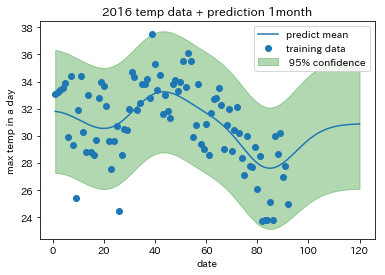

In [159]:
plot_result(x_test, pred_mean, pred_std)
plt.title("2016 temp data + prediction 1month")
plt.ylabel("max temp in a day")
plt.xlabel("date")
plt.legend()

うねりが正常だとすると、９５％信頼区間において低温側で２点を異常検知